In [1]:
library(data.table)
library(Matrix)
library(ggplot2)
theme_set(theme_bw(base_size = 16))
library(dplyr)
library(tidyr)
library(ggvenn)

Loading required package: grid

Loading required package: futile.logger


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack




In [2]:
setwd("/home/ocarpentier")

### Create a subset of GENIE3 relationships to compare with relationships of Targetscan  :

In [3]:
GENIE3_linklist <- data.table::fread(file = "work/result/genie3/GENIE3_score_filtered.csv",col.names = c("RegulatoryGene", "TargetGene", "Weight"), sep=",",data.table=TRUE)

In [4]:
#Sort by GENIE3 score
threshold = 1000000
GENIE3_linklist_ordered = GENIE3_linklist[order(-GENIE3_linklist$Weight), ]
print(GENIE3_linklist_ordered[threshold, ])

   RegulatoryGene       TargetGene      Weight
           <char>           <char>       <num>
1:  mirdeep2.2762 LOC_000000176360 0.005519142


In [5]:
Targetscan <- data.table::fread(file = "work/result/aggregation/targetscan_gene_mirdeep_known_filtered.csv",col.names = c("TargetGene","RegulatoryGene","Type","Start","End"), sep=",",data.table=FALSE)
Targetscan_linklist = unique(Targetscan[,c("TargetGene","RegulatoryGene")])

In [6]:
write.table(GENIE3_linklist_ordered[1:threshold,c("RegulatoryGene","TargetGene")], 
          file = "work/result/notebook/subset_couple_GENIE3_threshold_1M.csv", 
          row.names = FALSE, 
          col.names = FALSE,
          quote = FALSE,
          sep = ",")

### Retrieve informations in Multireg :

#### GENIE3
Run this lines before continue :
```bash
sed 's/"//g' /home/ocarpentier/work/result/notebook/subset_couple_GENIE3_threshold_1M.csv > /home/ocarpentier/work/result/notebook/subset_couple_GENIE3_threshold_1M.temp && mv /home/ocarpentier/work/result/notebook/subset_couple_GENIE3_threshold_1M.temp /home/ocarpentier/work/result/notebook/subset_couple_GENIE3_threshold_1M.csv
# Create an index to faster the query
cypher-shell -u neo4jE -p multireg "CREATE INDEX name_gene IF NOT EXISTS FOR (g:Gene) ON (g.name)"
cypher-shell -u neo4jE -p multireg "CREATE INDEX name_mirna IF NOT EXISTS FOR (m:miRNA) ON (m.name)"
# Retrieve informations in graphe
cypher-shell -u neo4j -p multireg "LOAD CSV WITH HEADERS FROM 'file:///home/ocarpentier/work/result/notebook/subset_couple_GENIE3_threshold_1M.csv' AS file MATCH (m:miRNA {name : file.RegulatoryGene})-[s:GENIE3_INFERENCE_SCORE]->(g:Gene {name: file.TargetGene}) RETURN DISTINCT m.name AS RegulatoryGene,g.name AS TargetGene,s.score AS ScoreGENIE3,g.biotype AS Biotype,g.transcript AS NbTranscripts" > /home/ocarpentier/work/result/cypher/relationships_by_couple_subsetGENIE3_threshold_1M.csv
```

#### Targetscan
Run this lines before continue :
```bash
cypher-shell -u neo4j -p multireg "MATCH (m:miRNA)-[t:TARGETS]->(g:Gene) RETURN DISTINCT m.name AS RegulatoryGene,g.name AS TargetGene,t.type AS TargetType,g.biotype AS Biotype,g.transcript AS NbTranscripts" > /home/ocarpentier/work/result/cypher/relationships_by_couple_Targetscan.csv
```


### Add expression correlation

In [7]:
exp_cor <- data.table::fread(file = "work/result/cypher/val_cor_biotype_transcript.csv",header=TRUE, sep=",",data.table=FALSE)

In [8]:
exp_cor$Correlation <- ifelse(exp_cor$Value < 0, "-", "+")

In [9]:
head(exp_cor)

RegulatoryGene TargetGene       Value       Biotype NbTranscripts Correlation
1 mirdeep2.7     LOC_000000221661 -0.03687736 lncRNA  1             -          
2 mirdeep2.7     LOC_000000221641  0.07521847 lncRNA  1             +          
3 mirdeep2.7     LOC_000000221639 -0.01670264 mRNA    1             -          
4 mirdeep2.7     LOC_000000221638 -0.05279771 lncRNA  1             -          
5 mirdeep2.7     LOC_000000221606 -0.02524824 mRNA    1             -          
6 mirdeep2.7     LOC_000000221589 -0.01690333 lncRNA  1             -

In [10]:
relationships_by_couple_subsetGENIE3_threshold_1M <- data.table::fread(file = "work/result/cypher/relationships_by_couple_subsetGENIE3_threshold_1M.csv",header=TRUE, sep=",",data.table=FALSE)

In [11]:
relationships_by_couple_subsetGENIE3_threshold_1M_corr <- merge(relationships_by_couple_subsetGENIE3_threshold_1M, exp_cor[, c("RegulatoryGene", "TargetGene", "Value","Correlation")], by = c("RegulatoryGene", "TargetGene"), all.x = TRUE)

In [12]:
head(relationships_by_couple_subsetGENIE3_threshold_1M_corr)

RegulatoryGene TargetGene       ScoreGENIE3 Biotype NbTranscripts Value    
1 mirdeep2.100   LOC_000000000437 0.005802802 mRNA    45            0.4917602
2 mirdeep2.100   LOC_000000000857 0.007190095 mRNA    25            0.5706040
3 mirdeep2.100   LOC_000000001531 0.006279703 lncRNA   2            0.5928583
4 mirdeep2.100   LOC_000000001977 0.007263256 lncRNA   5            0.4692279
5 mirdeep2.100   LOC_000000002528 0.005892017 lncRNA   1            0.7865917
6 mirdeep2.100   LOC_000000002586 0.006202122 mRNA    12            0.4260239
  Correlation
1 +          
2 +          
3 +          
4 +          
5 +          
6 +

In [13]:
relationships_by_couple_Targetscan <- data.table::fread(file = "work/result/cypher/relationships_by_couple_Targetscan.csv",header=TRUE, sep=",",data.table=FALSE)

In [14]:
relationships_by_couple_Targetscan_corr <- merge(relationships_by_couple_Targetscan, exp_cor[, c("RegulatoryGene", "TargetGene", "Value","Correlation")], by = c("RegulatoryGene", "TargetGene"), all.x = TRUE)

In [15]:
head(relationships_by_couple_Targetscan_corr)

RegulatoryGene TargetGene       TargetType Biotype NbTranscripts Value    
1 mirdeep2.1014  LOC_000000000000 6mer       lncRNA  21            -0.226689
2 mirdeep2.1014  LOC_000000000000 6mer       lncRNA  21            -0.226689
3 mirdeep2.1014  LOC_000000000000 6mer       lncRNA  21            -0.226689
4 mirdeep2.1014  LOC_000000000000 6mer       lncRNA  21            -0.226689
5 mirdeep2.1014  LOC_000000000000 6mer       lncRNA  21            -0.226689
6 mirdeep2.1014  LOC_000000000000 6mer       lncRNA  21            -0.226689
  Correlation
1 -          
2 -          
3 -          
4 -          
5 -          
6 -

### Find common relationships between GENIE3 (subset) and Targetscan :

In [16]:
intersection <- intersect(relationships_by_couple_Targetscan_corr[,c("RegulatoryGene","TargetGene")], relationships_by_couple_subsetGENIE3_threshold_1M_corr[,c("RegulatoryGene","TargetGene")])
dim(intersection) # 224035 relations

[1] 71726     2

In [17]:
head(intersection)

RegulatoryGene TargetGene      
1 mirdeep2.1014  LOC_000000000024
2 mirdeep2.1014  LOC_000000000135
3 mirdeep2.1014  LOC_000000000151
4 mirdeep2.1014  LOC_000000000232
5 mirdeep2.1014  LOC_000000000292
6 mirdeep2.1014  LOC_000000000354

In [18]:
intersection$Status <- "Common"
head(intersection)

RegulatoryGene TargetGene       Status
1 mirdeep2.1014  LOC_000000000024 Common
2 mirdeep2.1014  LOC_000000000135 Common
3 mirdeep2.1014  LOC_000000000151 Common
4 mirdeep2.1014  LOC_000000000232 Common
5 mirdeep2.1014  LOC_000000000292 Common
6 mirdeep2.1014  LOC_000000000354 Common

In [19]:
#add TargetScan information to common relationships
relationships_by_couple_Targetscan_corr_status <- merge(relationships_by_couple_Targetscan_corr, intersection, by = c("RegulatoryGene", "TargetGene"),all.x = TRUE)

In [20]:
#added a priority order for site types to filter relationships, keeping only the best TargetScan relationship for a couple
target_priority <- c("8mer-1a", "7mer-m8", "7mer-1a", "6mer")
relationships_by_couple_Targetscan_corr_status$TargetType <- factor(relationships_by_couple_Targetscan_corr_status$TargetType, levels = target_priority)

In [21]:
head(relationships_by_couple_Targetscan_corr_status)

RegulatoryGene TargetGene       TargetType Biotype NbTranscripts Value    
1 mirdeep2.1014  LOC_000000000000 6mer       lncRNA  21            -0.226689
2 mirdeep2.1014  LOC_000000000000 6mer       lncRNA  21            -0.226689
3 mirdeep2.1014  LOC_000000000000 6mer       lncRNA  21            -0.226689
4 mirdeep2.1014  LOC_000000000000 6mer       lncRNA  21            -0.226689
5 mirdeep2.1014  LOC_000000000000 6mer       lncRNA  21            -0.226689
6 mirdeep2.1014  LOC_000000000000 6mer       lncRNA  21            -0.226689
  Correlation Status
1 -           NA    
2 -           NA    
3 -           NA    
4 -           NA    
5 -           NA    
6 -           NA

In [22]:
relationships_by_couple_Targetscan_corr_status$Status = ifelse(is.na(relationships_by_couple_Targetscan_corr_status$Status), "Unique", relationships_by_couple_Targetscan_corr_status$Status)

In [23]:
head(relationships_by_couple_Targetscan_corr_status)

RegulatoryGene TargetGene       TargetType Biotype NbTranscripts Value    
1 mirdeep2.1014  LOC_000000000000 6mer       lncRNA  21            -0.226689
2 mirdeep2.1014  LOC_000000000000 6mer       lncRNA  21            -0.226689
3 mirdeep2.1014  LOC_000000000000 6mer       lncRNA  21            -0.226689
4 mirdeep2.1014  LOC_000000000000 6mer       lncRNA  21            -0.226689
5 mirdeep2.1014  LOC_000000000000 6mer       lncRNA  21            -0.226689
6 mirdeep2.1014  LOC_000000000000 6mer       lncRNA  21            -0.226689
  Correlation Status
1 -           Unique
2 -           Unique
3 -           Unique
4 -           Unique
5 -           Unique
6 -           Unique

In [24]:
##add GENIE3 information to common relationships
relationships_by_couple_subsetGENIE3_threshold_1M_corr_status = merge(relationships_by_couple_subsetGENIE3_threshold_1M_corr, intersection, by = c("RegulatoryGene", "TargetGene"),all.x = TRUE)

In [25]:
relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$Status = ifelse(is.na(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$Status), "Unique", relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$Status)

In [26]:
head(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status)

RegulatoryGene TargetGene       ScoreGENIE3 Biotype NbTranscripts Value    
1 mirdeep2.100   LOC_000000000437 0.005802802 mRNA    45            0.4917602
2 mirdeep2.100   LOC_000000000857 0.007190095 mRNA    25            0.5706040
3 mirdeep2.100   LOC_000000001531 0.006279703 lncRNA   2            0.5928583
4 mirdeep2.100   LOC_000000001977 0.007263256 lncRNA   5            0.4692279
5 mirdeep2.100   LOC_000000002528 0.005892017 lncRNA   1            0.7865917
6 mirdeep2.100   LOC_000000002586 0.006202122 mRNA    12            0.4260239
  Correlation Status
1 +           Unique
2 +           Unique
3 +           Unique
4 +           Unique
5 +           Unique
6 +           Unique

## Venn diagram of common relationships 

In [27]:
## Venn diagram
relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$Pair <- paste(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$RegulatoryGene, relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$TargetGene, sep="-")
relationships_by_couple_Targetscan_corr_status$Pair <- paste(relationships_by_couple_Targetscan_corr_status$RegulatoryGene, relationships_by_couple_Targetscan_corr_status$TargetGene, sep="-")
exp_cor$Pair <- paste(exp_cor$RegulatoryGene, exp_cor$TargetGene, sep="-")

list_of_pairs <- list(
  GENIE3 = relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$Pair,
  TargetScan = relationships_by_couple_Targetscan_corr_status$Pair,
  Correlation = exp_cor$Pair[which(exp_cor$Value < 0)]
)

In [28]:
venn_targetscan_genie3_corneg = ggvenn(list_of_pairs, c("GENIE3", "TargetScan", "Correlation"),show_percentage = FALSE,
      set_name_size = 5,fill_alpha=0.4,
      stroke_size=0.2,text_size = 5)

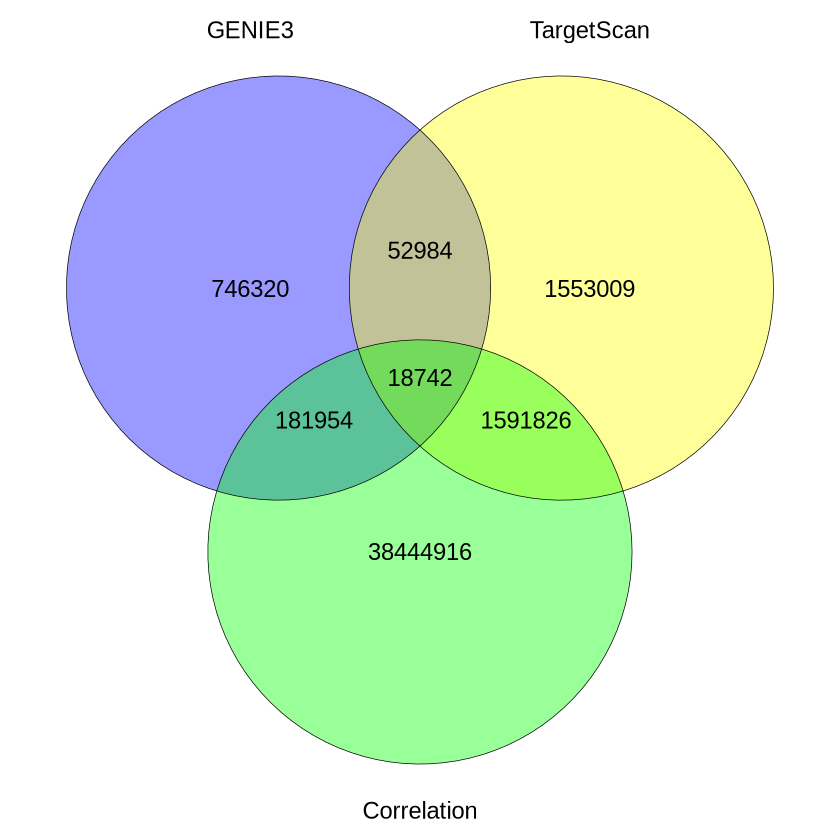

In [29]:
venn_targetscan_genie3_corneg

# GENIE3

### Average expression correlation value

In [30]:
aggregate(Value ~ Correlation + Status,data = relationships_by_couple_subsetGENIE3_threshold_1M_corr_status, 
                            mean, na.rm = TRUE)

Correlation Status Value     
1 -           Common -0.5307580
2 +           Common  0.5391599
3 -           Unique -0.4962236
4 +           Unique  0.4918536

### Median expression correlation value

In [31]:
aggregate(Value ~ Correlation + Status,data = relationships_by_couple_subsetGENIE3_threshold_1M_corr_status, 
                            median, na.rm = TRUE)

Correlation Status Value     
1 -           Common -0.5613524
2 +           Common  0.5613404
3 -           Unique -0.5247732
4 +           Unique  0.5063312

### Distribution of expression correlation value for GENIE3 relationships

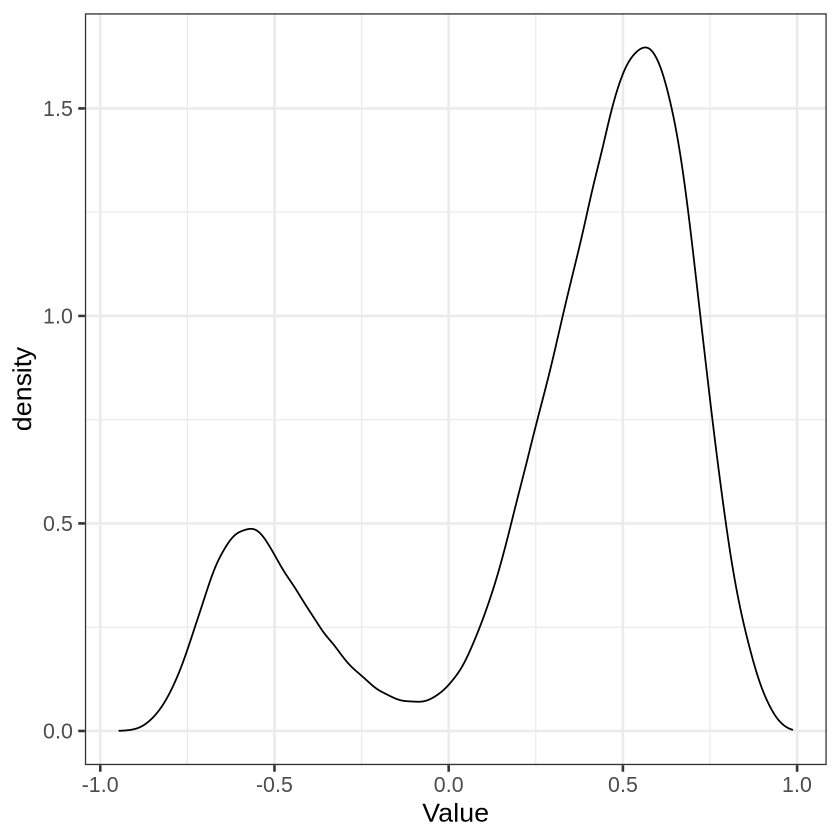

In [32]:
ggplot()+ geom_density(data=relationships_by_couple_subsetGENIE3_threshold_1M_corr_status,aes(x=Value,y = after_stat(density)),alpha=.2)

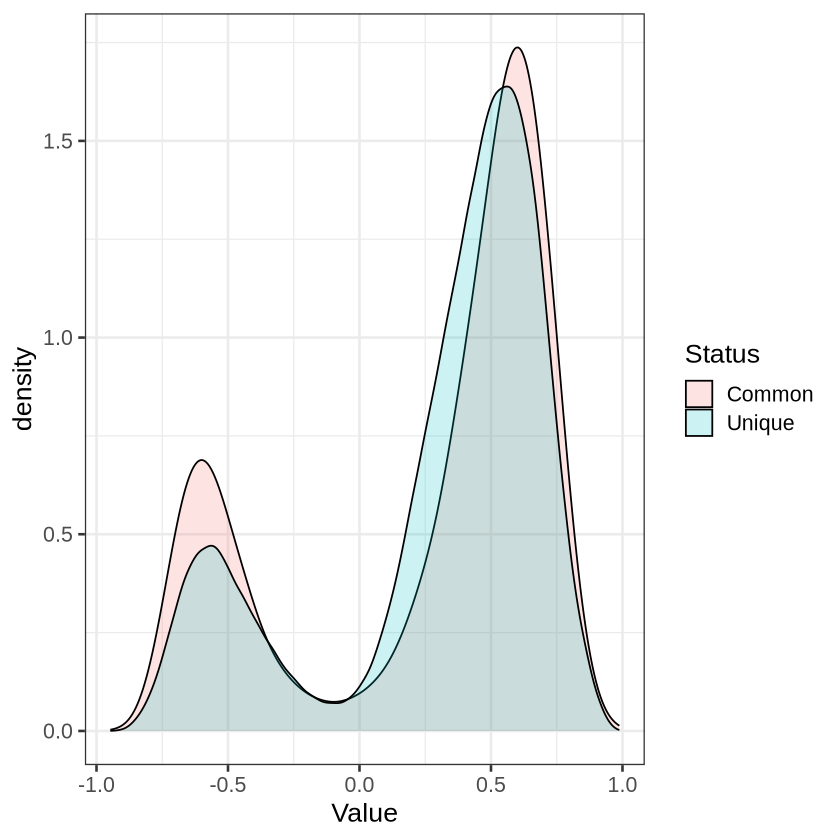

In [33]:
ggplot()+ geom_density(data=relationships_by_couple_subsetGENIE3_threshold_1M_corr_status,aes(x=Value,y = after_stat(density),fill=Status),alpha=.2)

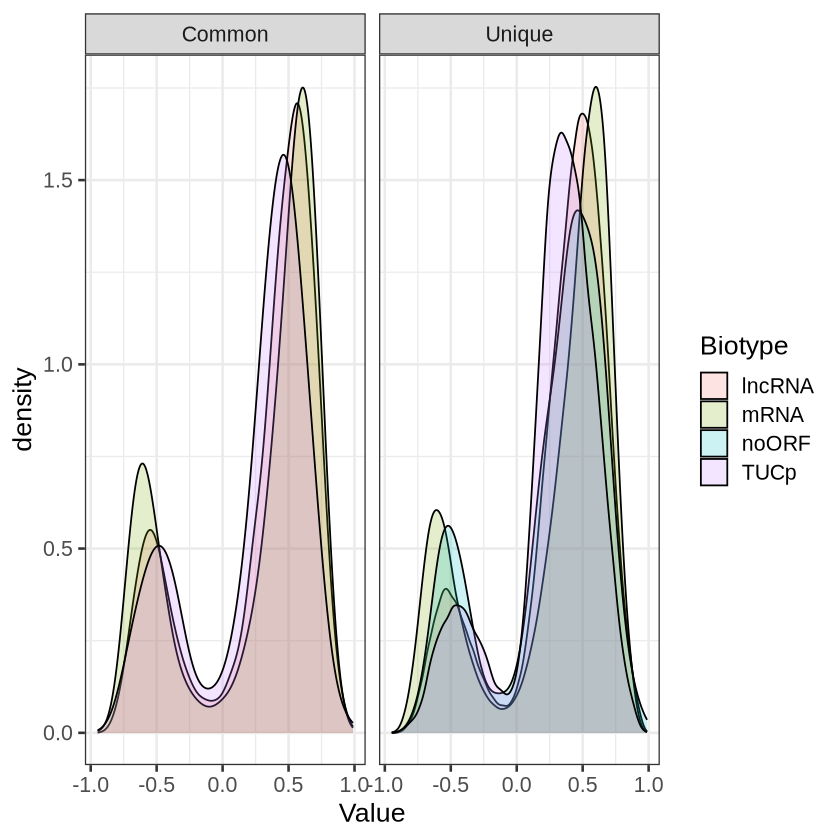

In [34]:
ggplot()+ geom_density(data=relationships_by_couple_subsetGENIE3_threshold_1M_corr_status,aes(x=Value,y = after_stat(density), fill=Biotype),alpha=.2) +facet_wrap( ~ Status)

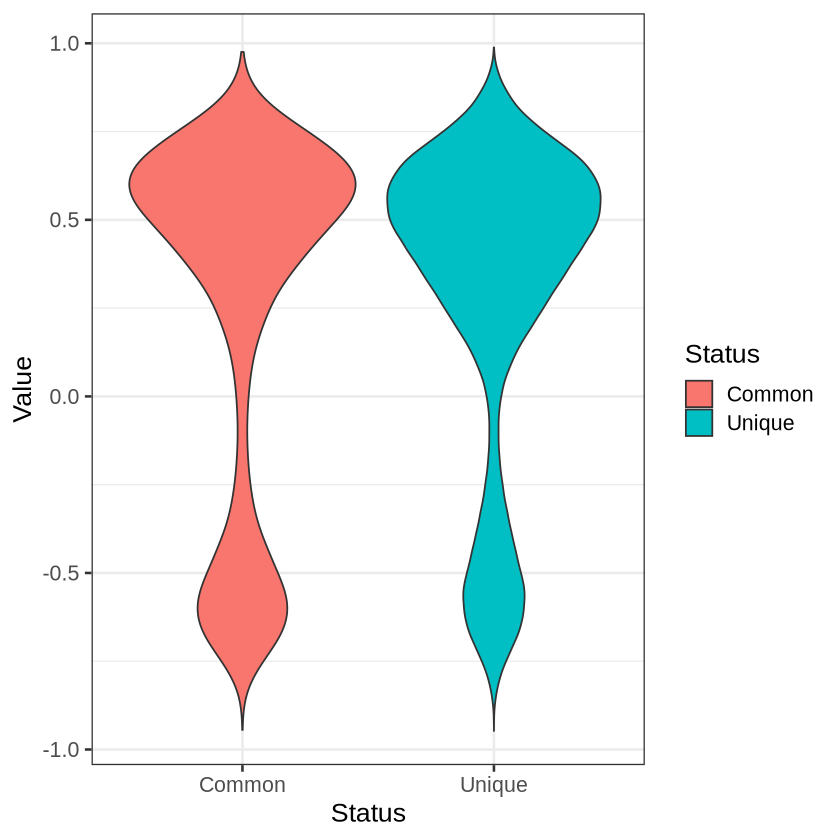

In [38]:
#GENIE3 relationships also predicted by TargetScan (common) or only predicted by GENIE3 (unique)
ggplot(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status, aes(x = Status, y = Value, fill = Status)) +
  geom_violin()

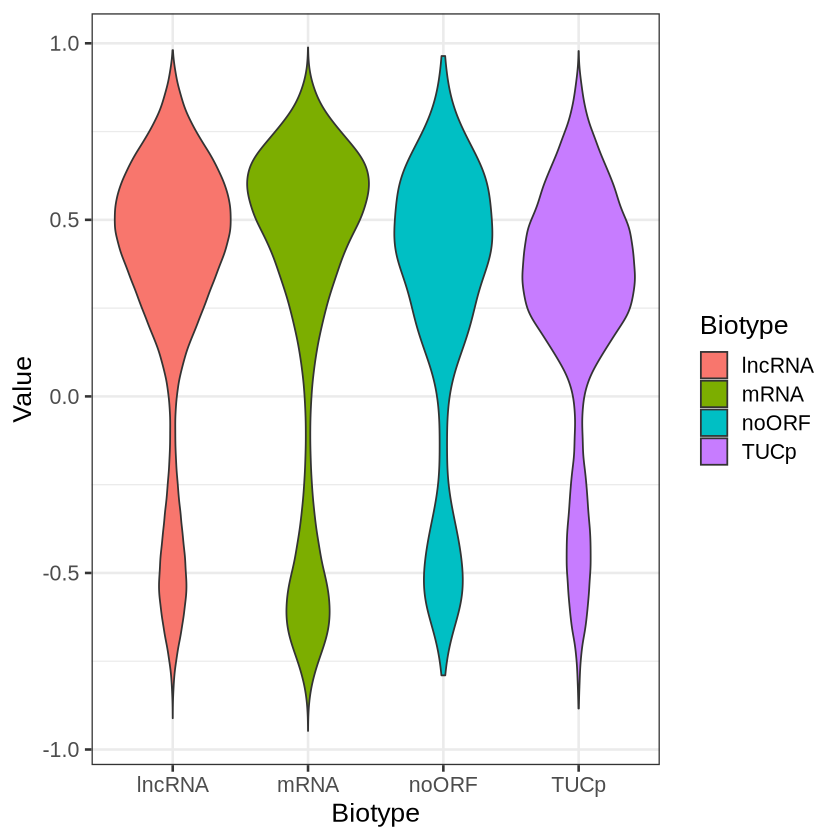

In [39]:
#Depending on target gene biotype
ggplot(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status, aes(x = Biotype, y = Value, fill = Biotype)) +
  geom_violin()

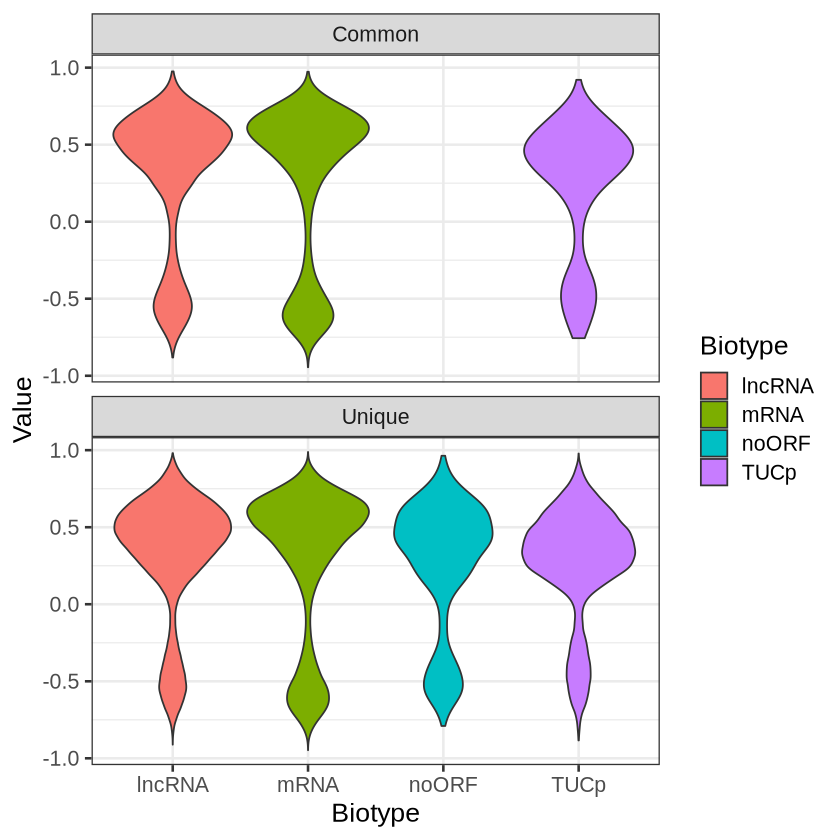

In [40]:
#GENIE3 relationships also predicted by TargetScan (common) or only by GENIE3 (unique) depending on target gene biotype
ggplot(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status, aes(x = Biotype, y = Value, fill = Biotype)) +
  geom_violin() + facet_wrap(~ Status,nrow = 2)

### Ranking of expression correlation value for GENIE3 relationships

In [35]:
subsetGENIE3_threshold_1M_corr_sorted= relationships_by_couple_subsetGENIE3_threshold_1M_corr_status[order(-abs(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$Value)), ]
subsetGENIE3_threshold_1M_corr_sorted$Rank = 1:nrow(subsetGENIE3_threshold_1M_corr_sorted)
head(subsetGENIE3_threshold_1M_corr_sorted)

RegulatoryGene TargetGene       ScoreGENIE3 Biotype NbTranscripts
780258 mirdeep2.5483  LOC_000000113351 0.02384376  mRNA    2            
630577 mirdeep2.4551  LOC_000000064314 0.03466791  mRNA    1            
932365 mirdeep2.6361  LOC_000000068798 0.01338850  mRNA    1            
587816 mirdeep2.4259  LOC_000000064997 0.02190547  lncRNA  2            
932330 mirdeep2.6361  LOC_000000064997 0.02409530  lncRNA  2            
952448 mirdeep2.7     LOC_000000097612 0.02170454  TUCp    1            
       Value     Correlation Status Pair                           Rank
780258 0.9881829 +           Unique mirdeep2.5483-LOC_000000113351 1   
630577 0.9870958 +           Unique mirdeep2.4551-LOC_000000064314 2   
932365 0.9810688 +           Unique mirdeep2.6361-LOC_000000068798 3   
587816 0.9806209 +           Unique mirdeep2.4259-LOC_000000064997 4   
932330 0.9802293 +           Unique mirdeep2.6361-LOC_000000064997 5   
952448 0.9780210 +           Unique mirdeep2.7-LOC_000000097612    6

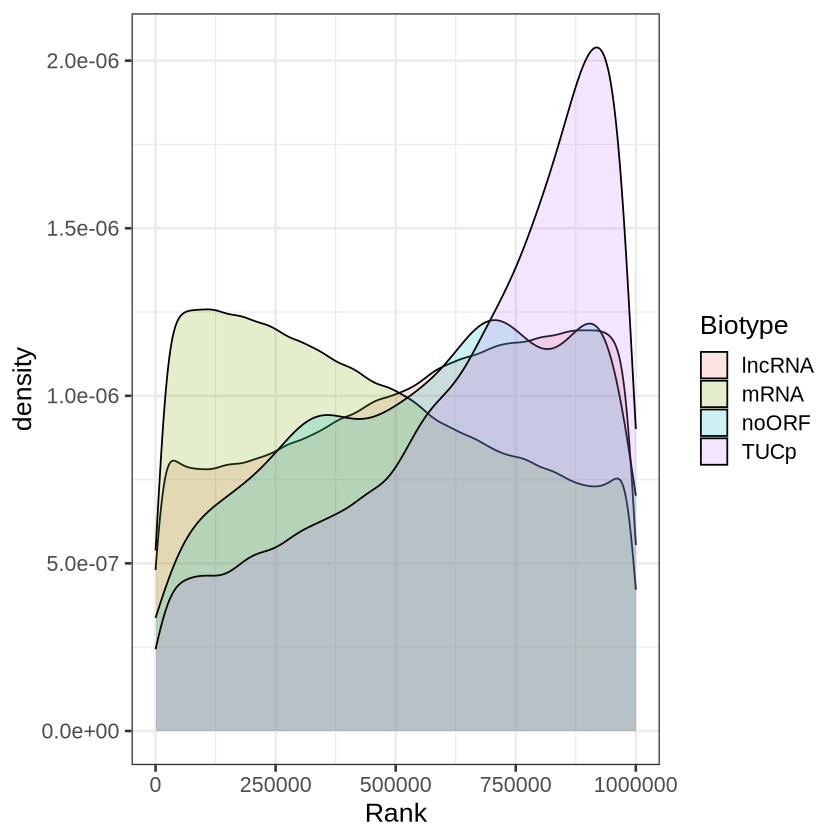

In [36]:
ggplot()+ geom_density(data=subsetGENIE3_threshold_1M_corr_sorted,aes(x=Rank,y = after_stat(density), fill=Biotype),alpha=.2)

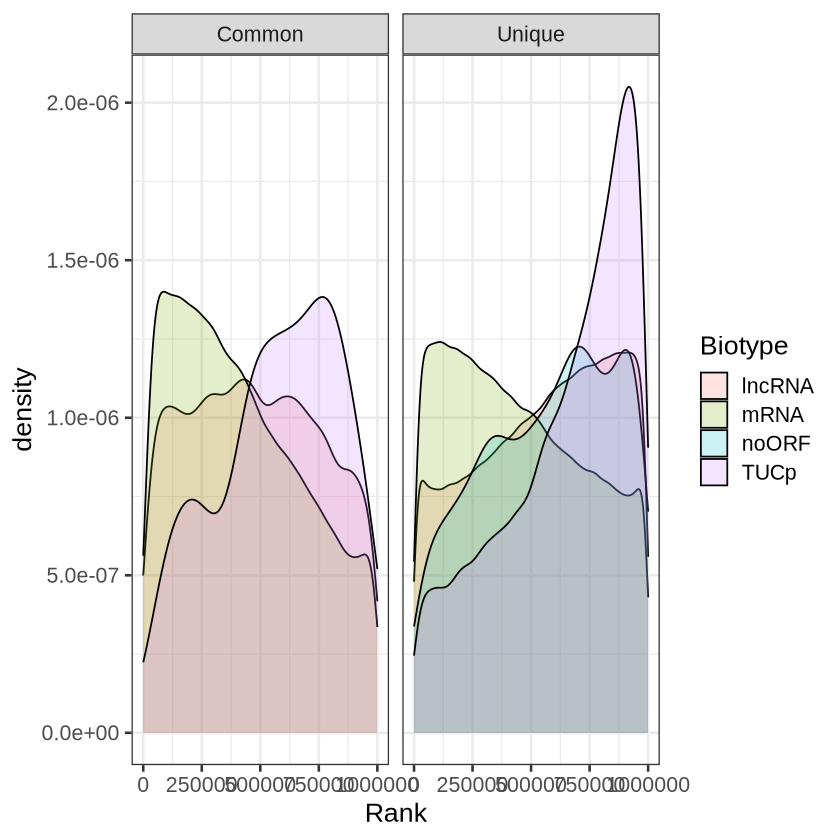

In [37]:
#GENIE3 relationships also predicted by TargetScan (common) or only by GENIE3 (unique) depending on target gene biotype
ggplot()+ geom_density(data=subsetGENIE3_threshold_1M_corr_sorted,aes(x=Rank,y = after_stat(density), fill=Biotype),alpha=.2) +facet_wrap(~Status)

### Comparison GENIE3 score 

### Average GENIE3 score

In [43]:
aggregate(ScoreGENIE3 ~ Status, 
                            data = relationships_by_couple_subsetGENIE3_threshold_1M_corr_status, 
                            median, na.rm = TRUE)

Status ScoreGENIE3
1 Common 0.008604347
2 Unique 0.008671318

In [41]:
aggregate(ScoreGENIE3 ~ Correlation + Status,data = relationships_by_couple_subsetGENIE3_threshold_1M_corr_status, 
                            mean, na.rm = TRUE)

Correlation Status ScoreGENIE3
1 -           Common 0.009552204
2 +           Common 0.010259747
3 -           Unique 0.009727744
4 +           Unique 0.010327187

### Median GENIE3 score

In [42]:
aggregate(ScoreGENIE3 ~ Correlation + Status, 
                            data = relationships_by_couple_subsetGENIE3_threshold_1M_corr_status, 
                            median, na.rm = TRUE)

Correlation Status ScoreGENIE3
1 -           Common 0.008134933
2 +           Common 0.008784956
3 -           Unique 0.008253882
4 +           Unique 0.008783653

### Distribution of GENIE3 score

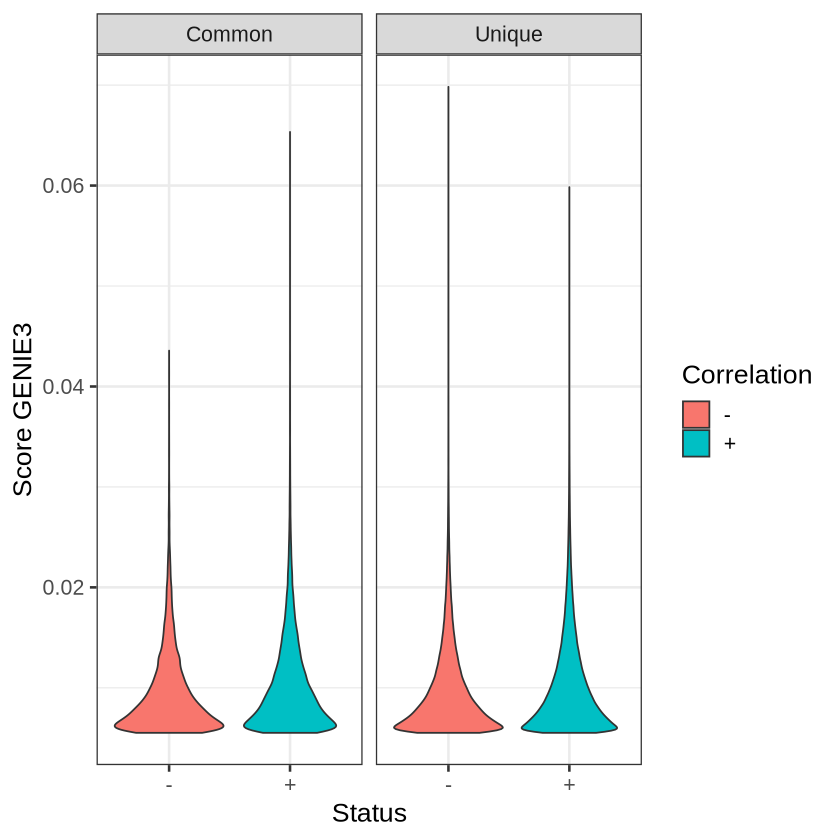

In [44]:
ggplot(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status, aes(x = Correlation, y = ScoreGENIE3, fill = Correlation)) +
  geom_violin() +
  labs(x = "Status",
       y = "Score GENIE3") + facet_wrap(~ Status)

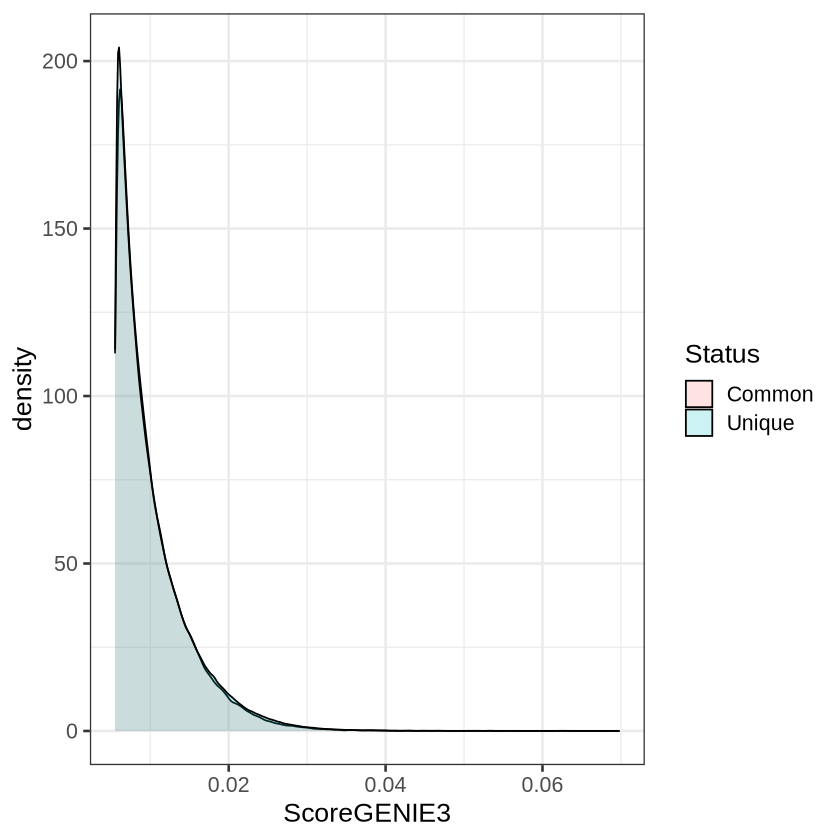

In [45]:
ggplot()+ geom_density(data=relationships_by_couple_subsetGENIE3_threshold_1M_corr_status,aes(x=ScoreGENIE3,y = after_stat(density),fill=Status),alpha=.2)

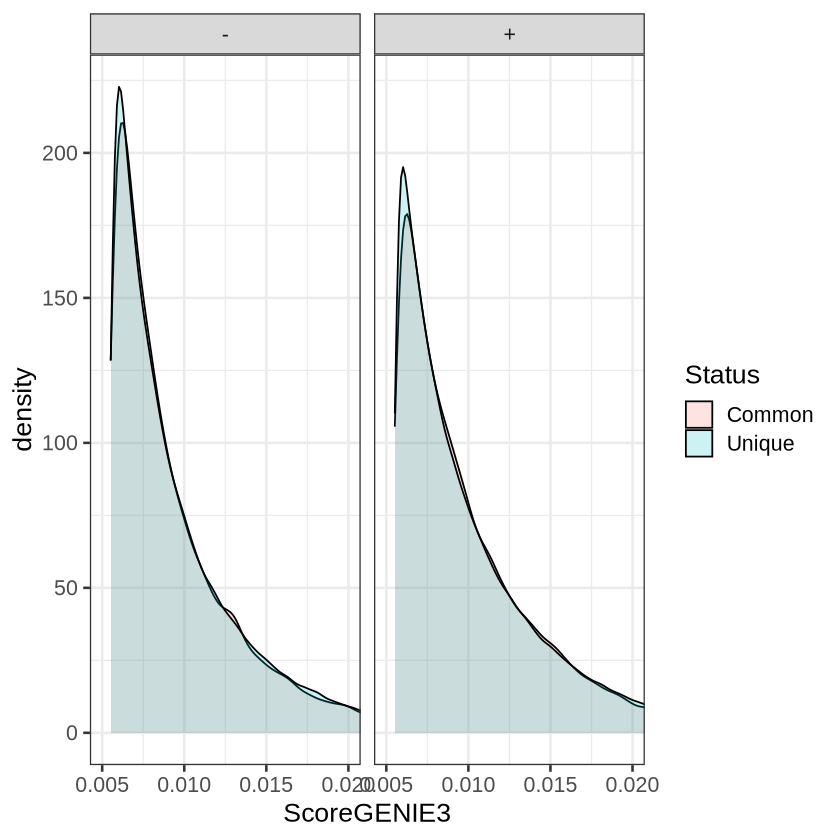

In [46]:
ggplot()+ geom_density(data=relationships_by_couple_subsetGENIE3_threshold_1M_corr_status,aes(x=ScoreGENIE3,y = after_stat(density),fill=Status),alpha=.2) + coord_cartesian(xlim = c(0.005,0.02)) + facet_wrap(~Correlation)

### Ranking of GENIE3 score

In [47]:
subsetGENIE3_threshold_1M_score_sorted= relationships_by_couple_subsetGENIE3_threshold_1M_corr_status[order(-relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$ScoreGENIE3), ]
subsetGENIE3_threshold_1M_score_sorted$Rank = 1:nrow(subsetGENIE3_threshold_1M_score_sorted)
head(subsetGENIE3_threshold_1M_score_sorted)

RegulatoryGene TargetGene       ScoreGENIE3 Biotype NbTranscripts
936181 mirdeep2.6402  LOC_000000009739 0.06983171  mRNA    15           
936149 mirdeep2.6402  LOC_000000006644 0.06920978  mRNA    21           
936305 mirdeep2.6402  LOC_000000026738 0.06872115  mRNA    10           
936443 mirdeep2.6402  LOC_000000072268 0.06680601  mRNA     9           
896165 mirdeep2.6179  LOC_000000006644 0.06534233  mRNA    21           
936124 mirdeep2.6402  LOC_000000004932 0.06478655  lncRNA   4           
       Value      Correlation Status Pair                           Rank
936181 -0.8681138 -           Unique mirdeep2.6402-LOC_000000009739 1   
936149 -0.8722917 -           Unique mirdeep2.6402-LOC_000000006644 2   
936305 -0.8894275 -           Unique mirdeep2.6402-LOC_000000026738 3   
936443 -0.8798196 -           Unique mirdeep2.6402-LOC_000000072268 4   
896165  0.9644169 +           Common mirdeep2.6179-LOC_000000006644 5   
936124 -0.8834886 -           Unique mirdeep2.6402-LOC_000000004932 6

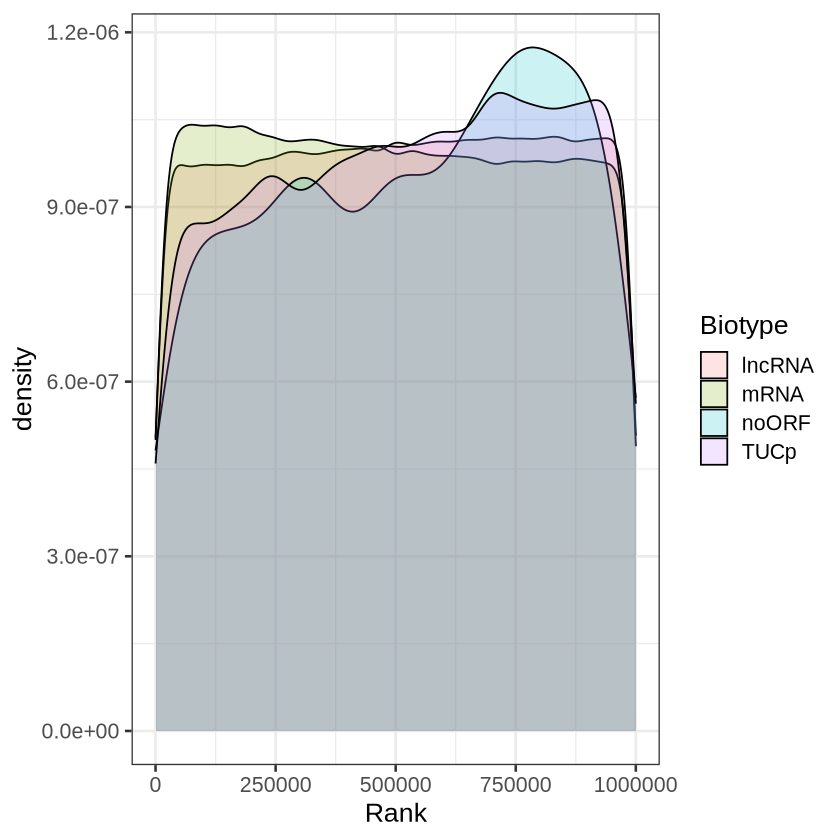

In [48]:
ggplot()+ geom_density(data=subsetGENIE3_threshold_1M_score_sorted,aes(x=Rank,y = after_stat(density), fill=Biotype),alpha=.2)

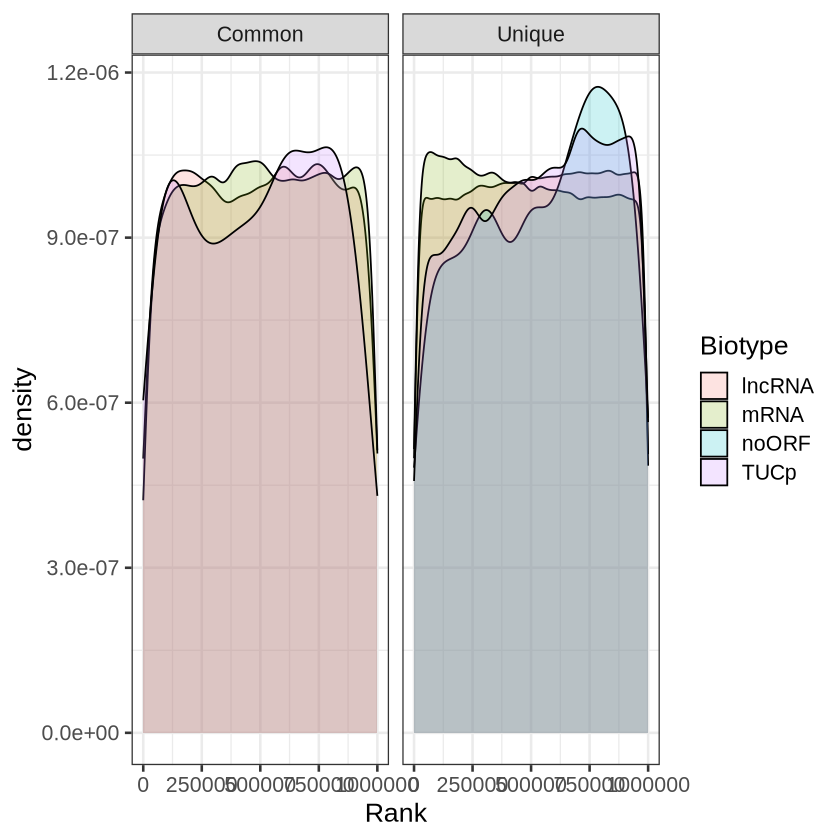

In [49]:
ggplot()+ geom_density(data=subsetGENIE3_threshold_1M_score_sorted,aes(x=Rank,y = after_stat(density), fill=Biotype),alpha=.2) + facet_wrap(~Status)

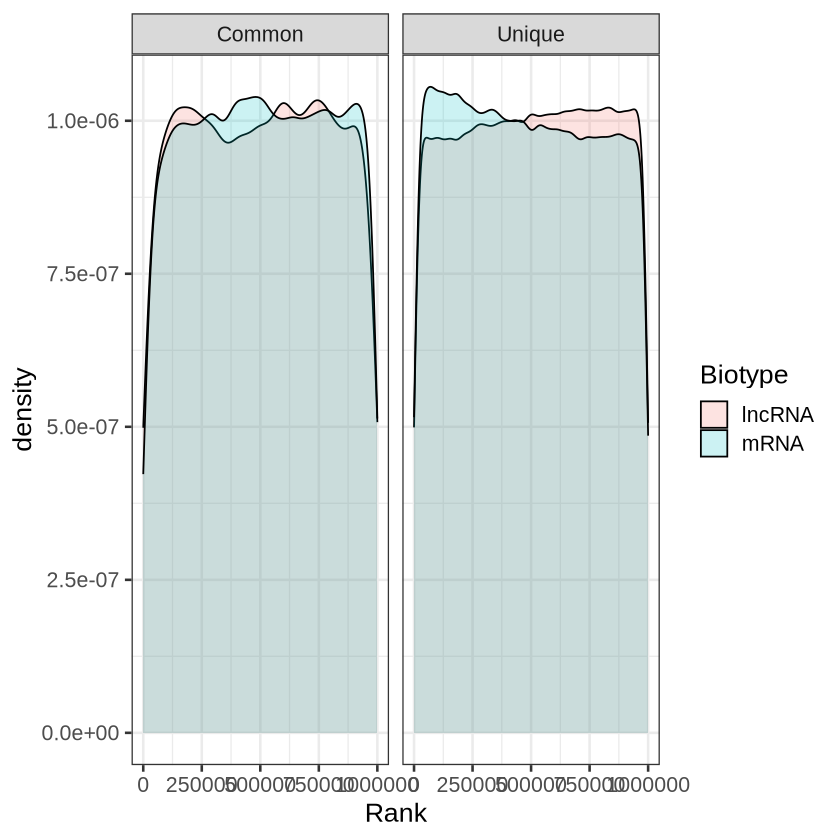

In [50]:
ggplot() +
  geom_density(data = subset(subsetGENIE3_threshold_1M_score_sorted, Biotype %in% c("mRNA", "lncRNA")),
               aes(x = Rank, y = after_stat(density), fill = Biotype), alpha = 0.2) + facet_wrap(~Status)

### Comparison expression correlation and GENIE3 score 

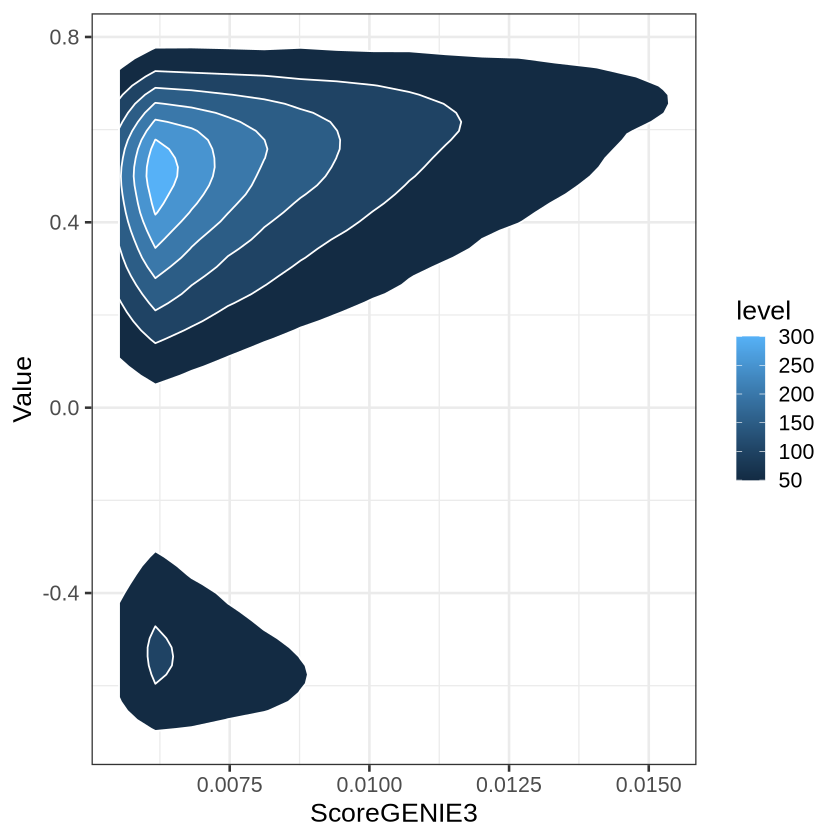

In [51]:
# Area + contour
ggplot(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status, aes(x=ScoreGENIE3, y=Value) ) +
  stat_density_2d(aes(fill = after_stat(level)), geom = "polygon", colour="white")

# Targetscan

### Average expression correlation value

In [52]:
aggregate(Value ~ Correlation + Status,data = relationships_by_couple_Targetscan_corr_status, 
                            mean, na.rm = TRUE)

Correlation Status Value     
1 -           Common -0.5340090
2 +           Common  0.5484293
3 -           Unique -0.2000262
4 +           Unique  0.2143073

### Median expression correlation value

In [53]:
aggregate(Value ~ Correlation + Status,data = relationships_by_couple_Targetscan_corr_status, 
                            median, na.rm = TRUE)

Correlation Status Value     
1 -           Common -0.5700913
2 +           Common  0.5712079
3 -           Unique -0.1703786
4 +           Unique  0.1812168

### Number of relationships by target type

In [54]:
relationships_by_couple_Targetscan_corr_status %>% group_by(TargetType) %>% summarise(Total = n()) 

TargetType Total  
1 8mer-1a     847695
2 7mer-m8    2277859
3 7mer-1a    2177191
4 6mer       5893195

In [55]:
targetType_totals <- relationships_by_couple_Targetscan_corr_status %>% filter(!is.na(Correlation)) %>% group_by(TargetType, Correlation, Status) %>% summarise(Total = n()) 
targetType_totals

`summarise()` has grouped output by 'TargetType', 'Correlation'. You can
override using the `.groups` argument.


TargetType Correlation Status Total  
1  8mer-1a    +           Common   14478
2  8mer-1a    +           Unique  423655
3  8mer-1a    -           Common    4960
4  8mer-1a    -           Unique  404595
5  7mer-m8    +           Common   39774
6  7mer-m8    +           Unique 1124356
7  7mer-m8    -           Common   13087
8  7mer-m8    -           Unique 1100623
9  7mer-1a    +           Common   37239
10 7mer-1a    +           Unique 1092163
11 7mer-1a    -           Common   12411
12 7mer-1a    -           Unique 1035346
13 6mer       +           Common   97238
14 6mer       +           Unique 2940336
15 6mer       -           Common   32001
16 6mer       -           Unique 2823555

In [56]:
targetType_totals_percentages = targetType_totals %>% group_by(Status,Correlation) %>% mutate(Percentage = (Total / sum(Total)) * 100)
targetType_totals_percentages

TargetType Correlation Status Total   Percentage
1  8mer-1a    +           Common   14478  7.671317 
2  8mer-1a    +           Unique  423655  7.591690 
3  8mer-1a    -           Common    4960  7.941209 
4  8mer-1a    -           Unique  404595  7.542618 
5  7mer-m8    +           Common   39774 21.074663 
6  7mer-m8    +           Unique 1124356 20.147908 
7  7mer-m8    -           Common   13087 20.952945 
8  7mer-m8    -           Unique 1100623 20.518244 
9  7mer-1a    +           Common   37239 19.731467 
10 7mer-1a    +           Unique 1092163 19.571025 
11 7mer-1a    -           Common   12411 19.870635 
12 7mer-1a    -           Unique 1035346 19.301324 
13 6mer       +           Common   97238 51.522554 
14 6mer       +           Unique 2940336 52.689378 
15 6mer       -           Common   32001 51.235210 
16 6mer       -           Unique 2823555 52.637814

### Distribution of target type

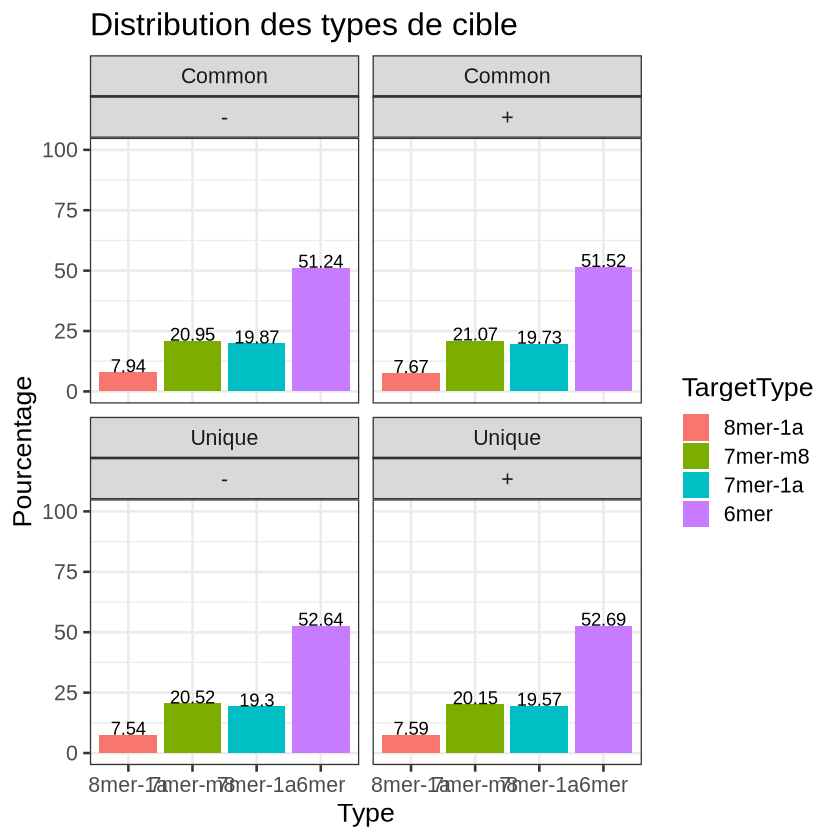

In [57]:
ggplot(targetType_totals_percentages, aes(x = TargetType, y=Percentage,fill=TargetType)) +
  geom_bar(stat='identity') +
  facet_wrap(~ Status+Correlation) + 
  labs(title = "Distribution des types de cible",
       x = "Type",
       y = "Pourcentage") +
  geom_text(aes(label = round(Percentage, 2)), position = position_dodge(width = 1), 
            vjust = "bottom", hjust = "center") +
  ylim(0,100)

### Distribution of expression correlation value

Warning message:
“Removed 123 rows containing non-finite outside the scale range
(`stat_density()`).”


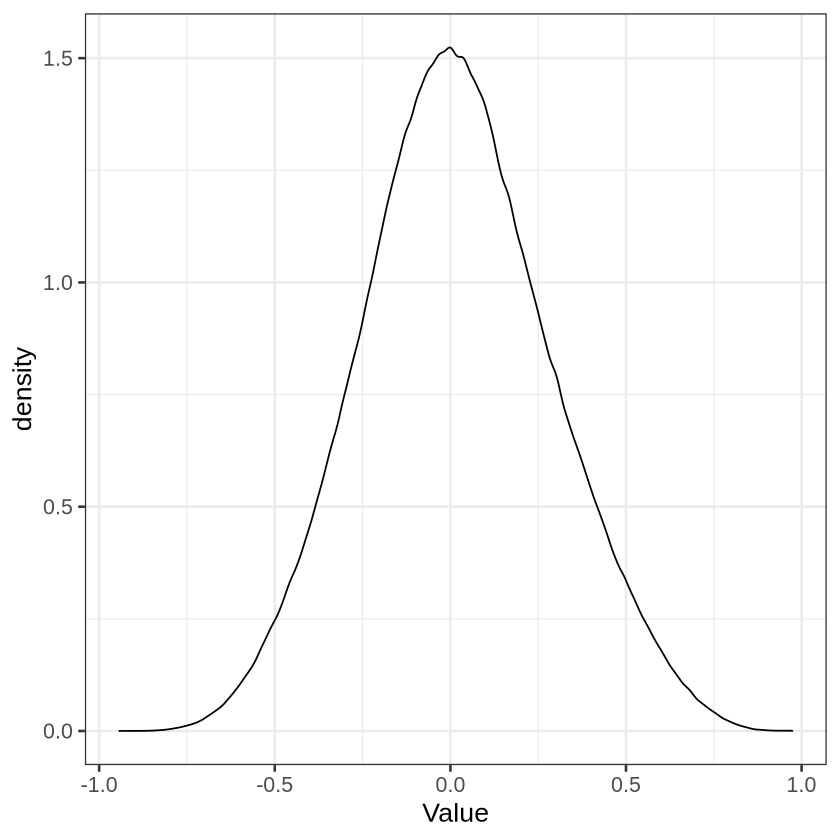

In [59]:
ggplot()+ geom_density(data=relationships_by_couple_Targetscan_corr_status,aes(x=Value,y = after_stat(density)),alpha=.2)

Warning message:
“Removed 123 rows containing non-finite outside the scale range
(`stat_density()`).”


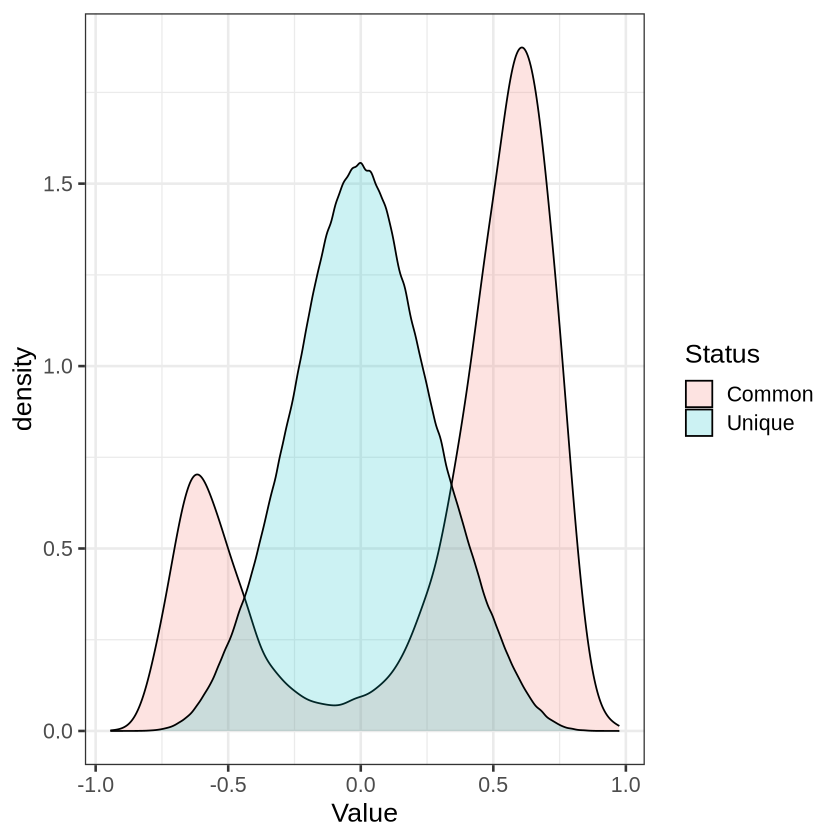

In [58]:
ggplot()+ geom_density(data=relationships_by_couple_Targetscan_corr_status,aes(x=Value,y = after_stat(density),fill=Status),alpha=.2)

Warning message:
“Removed 123 rows containing non-finite outside the scale range
(`stat_density()`).”


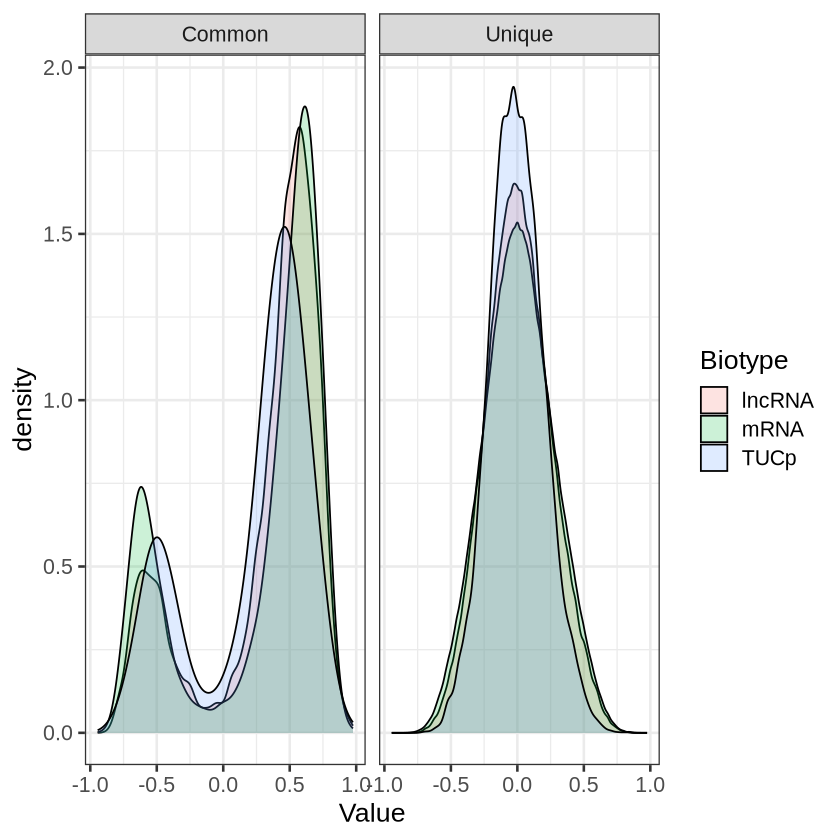

In [60]:
ggplot()+ geom_density(data=relationships_by_couple_Targetscan_corr_status,aes(x=Value,y = after_stat(density), fill=Biotype),alpha=.2) +facet_wrap( ~ Status)

Warning message:
“Removed 123 rows containing non-finite outside the scale range
(`stat_ydensity()`).”


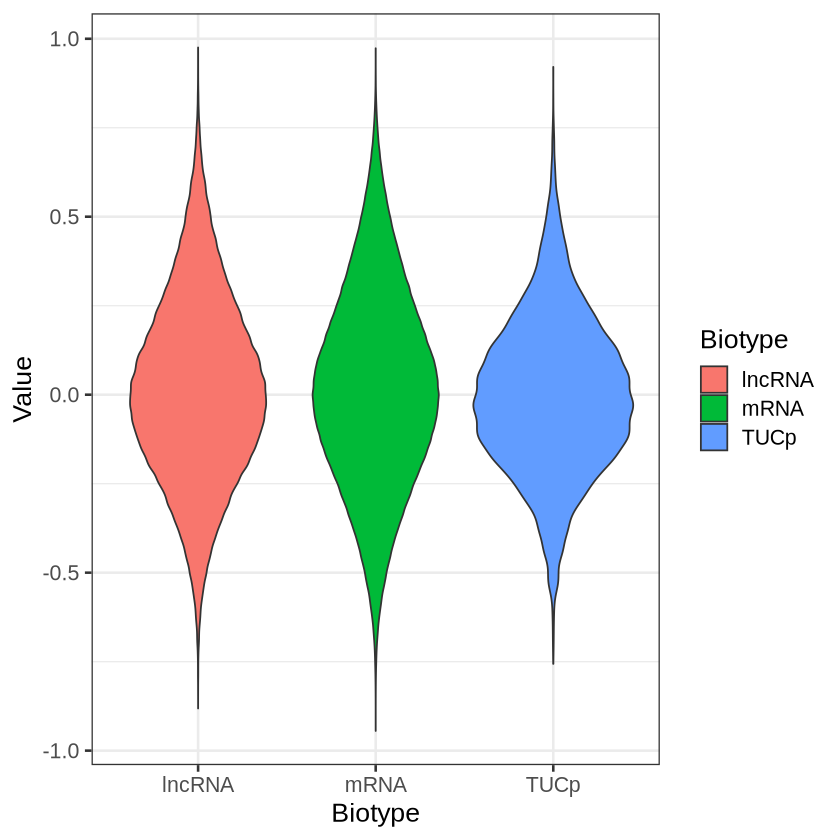

In [64]:
ggplot(relationships_by_couple_Targetscan_corr_status, aes(x = Biotype, y = Value, fill = Biotype)) +
  geom_violin()

Warning message:
“Removed 123 rows containing non-finite outside the scale range
(`stat_ydensity()`).”


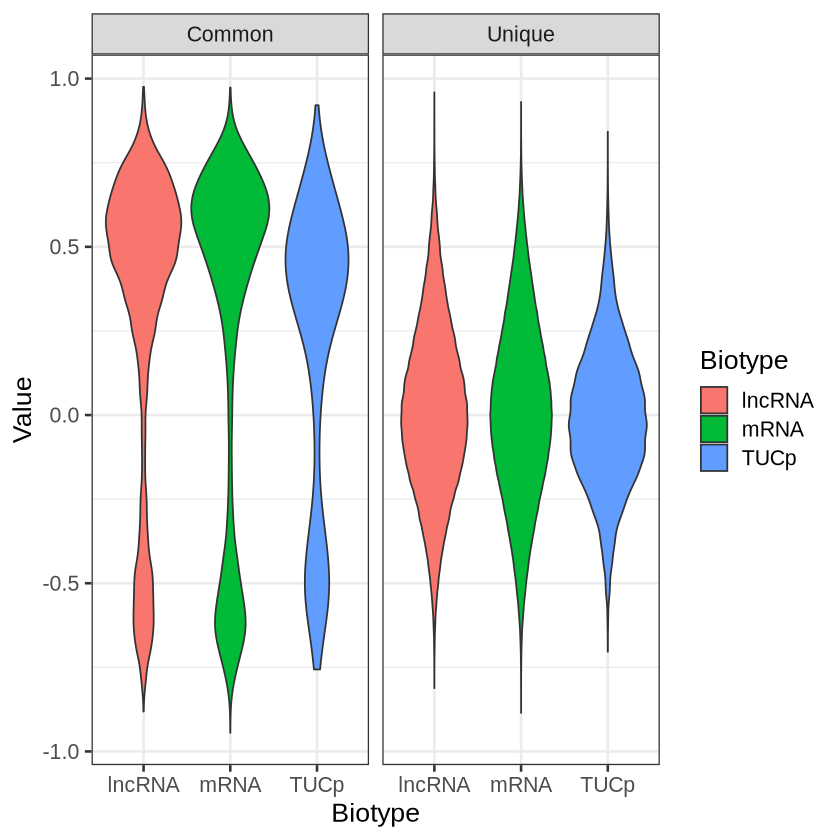

In [65]:
ggplot(relationships_by_couple_Targetscan_corr_status, aes(x = Biotype, y = Value, fill = Biotype)) +
  geom_violin() + facet_wrap(~ Status)

Warning message:
“Removed 123 rows containing non-finite outside the scale range
(`stat_ydensity()`).”


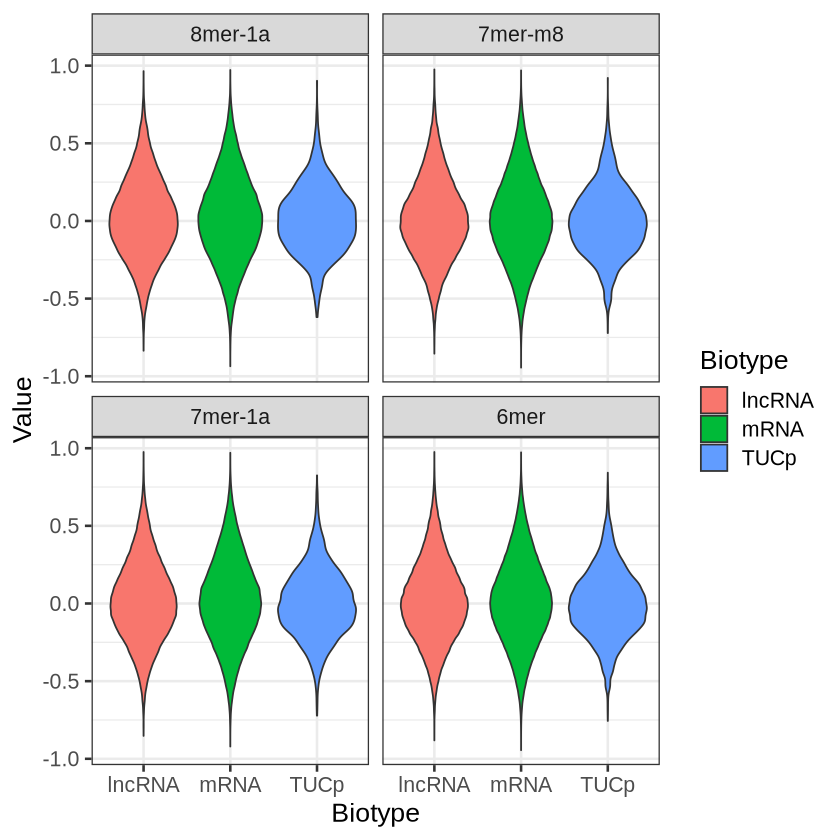

In [66]:
ggplot(relationships_by_couple_Targetscan_corr_status, aes(x = Biotype, y = Value, fill = Biotype)) +
  geom_violin() + facet_wrap(~ TargetType)

Warning message:
“Removed 123 rows containing non-finite outside the scale range
(`stat_ydensity()`).”


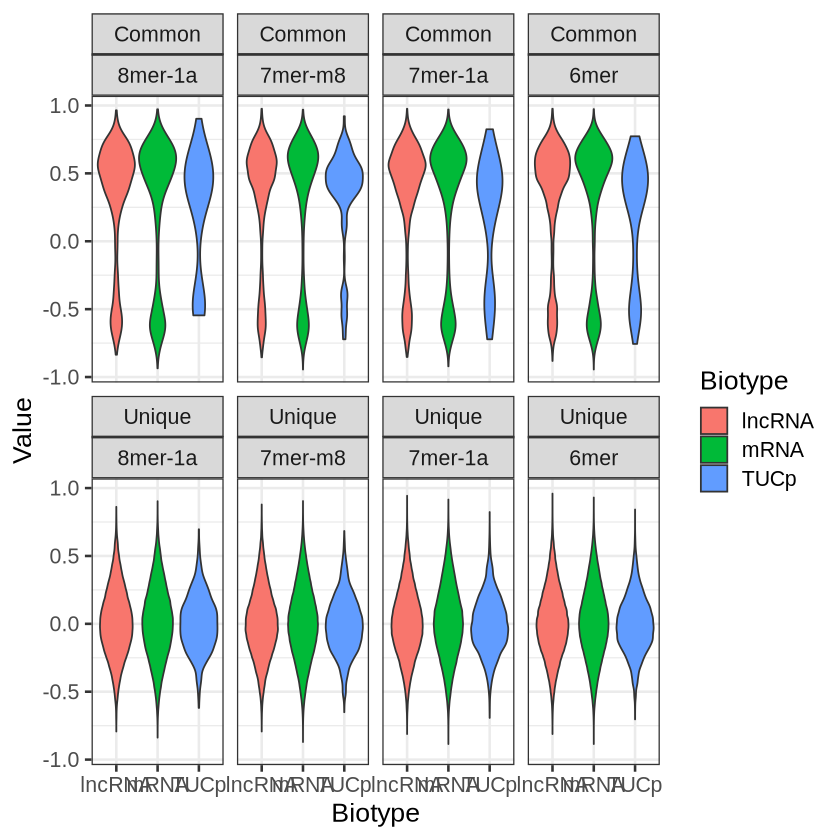

In [67]:
ggplot(relationships_by_couple_Targetscan_corr_status, aes(x = Biotype, y = Value, fill = Biotype)) +
  geom_violin() + facet_wrap(~ Status + TargetType, nrow = 2)

### Ranking of expression correlation value for TargetScan relationships

In [61]:
Targetscan_corr_sorted= relationships_by_couple_Targetscan_corr_status[order(-abs(relationships_by_couple_Targetscan_corr_status$Value)), ]
Targetscan_corr_sorted$Rank = 1:nrow(Targetscan_corr_sorted)
head(Targetscan_corr_sorted)

RegulatoryGene TargetGene       TargetType Biotype NbTranscripts
9863769 mirdeep2.6179  LOC_000000033005 7mer-1a    lncRNA  8            
9863770 mirdeep2.6179  LOC_000000033005 7mer-m8    lncRNA  8            
9863771 mirdeep2.6179  LOC_000000033005 6mer       lncRNA  8            
9863772 mirdeep2.6179  LOC_000000033005 7mer-m8    lncRNA  8            
9863773 mirdeep2.6179  LOC_000000033005 6mer       lncRNA  8            
9863774 mirdeep2.6179  LOC_000000033005 6mer       lncRNA  8            
        Value     Correlation Status Pair                           Rank
9863769 0.9755317 +           Common mirdeep2.6179-LOC_000000033005 1   
9863770 0.9755317 +           Common mirdeep2.6179-LOC_000000033005 2   
9863771 0.9755317 +           Common mirdeep2.6179-LOC_000000033005 3   
9863772 0.9755317 +           Common mirdeep2.6179-LOC_000000033005 4   
9863773 0.9755317 +           Common mirdeep2.6179-LOC_000000033005 5   
9863774 0.9755317 +           Common mirdeep2.6179-LOC_000000033005 6

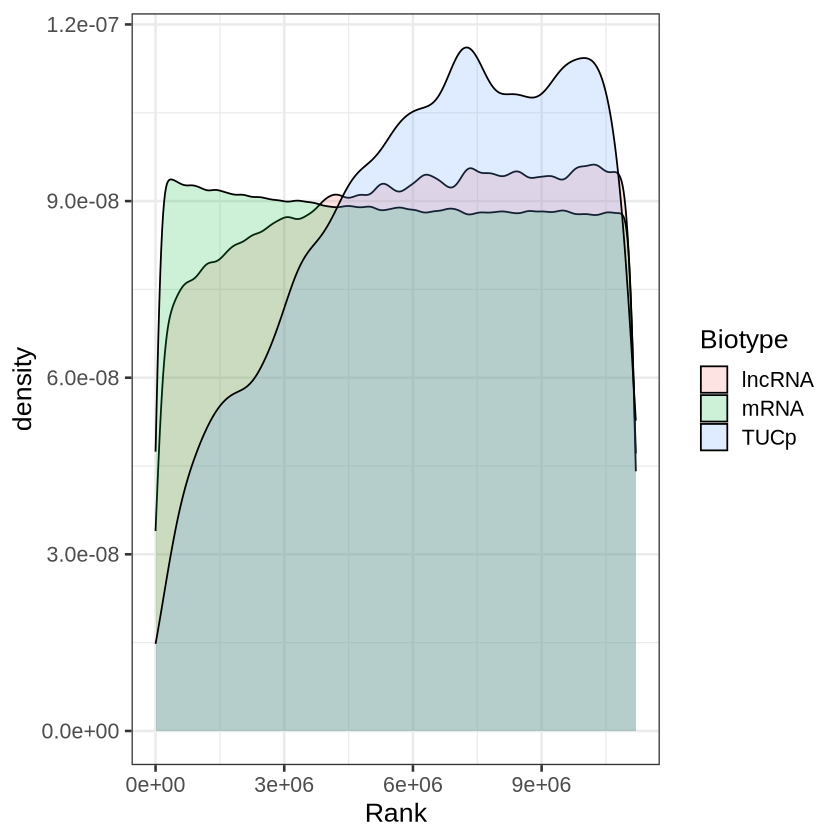

In [62]:
ggplot()+ geom_density(data=Targetscan_corr_sorted,aes(x=Rank,y = after_stat(density), fill=Biotype),alpha=.2)

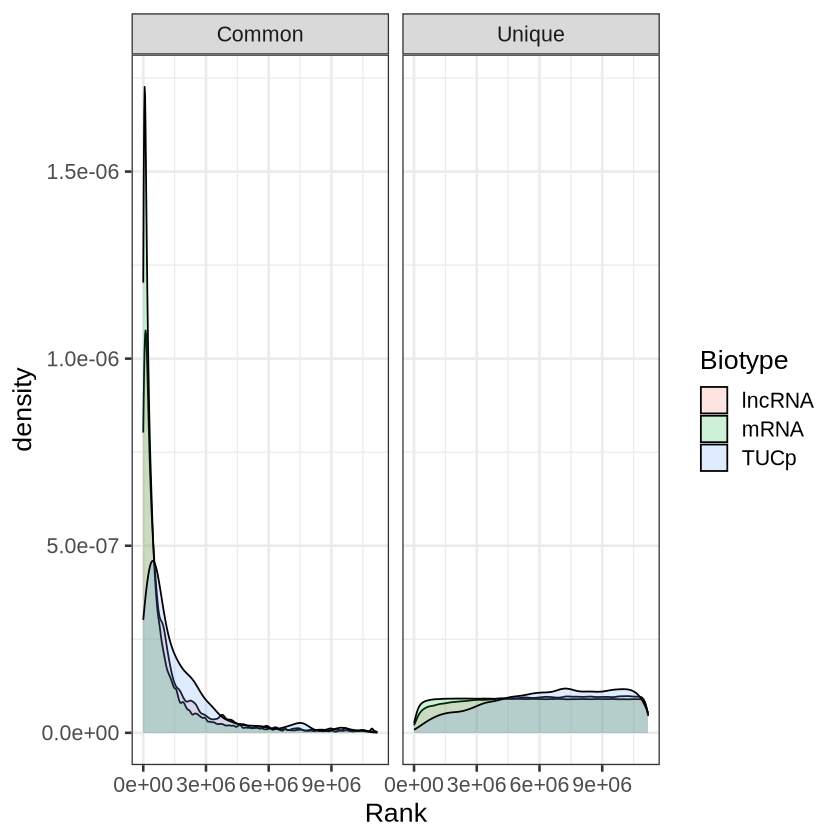

In [63]:
ggplot()+ geom_density(data=Targetscan_corr_sorted,aes(x=Rank,y = after_stat(density), fill=Biotype),alpha=.2) + facet_wrap(~Status)

# Common relationships with negative correlation

In [68]:
common_rel_neg_cor = relationships_by_couple_subsetGENIE3_threshold_1M_corr_status[which(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$Correlation == "-" & relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$Status == "Common"), ]

In [69]:
dim(common_rel_neg_cor)

[1] 18742     9

In [70]:
head(common_rel_neg_cor)

RegulatoryGene TargetGene       ScoreGENIE3 Biotype NbTranscripts
2914 mirdeep2.1014  LOC_000000000024 0.006462466 mRNA     5           
2933 mirdeep2.1014  LOC_000000000841 0.005636815 mRNA    24           
2937 mirdeep2.1014  LOC_000000001095 0.006229797 mRNA     9           
2943 mirdeep2.1014  LOC_000000001224 0.005807279 mRNA    47           
2947 mirdeep2.1014  LOC_000000001382 0.006959888 mRNA    14           
2968 mirdeep2.1014  LOC_000000002599 0.008060518 mRNA    12           
     Value      Correlation Status Pair                          
2914 -0.4844046 -           Common mirdeep2.1014-LOC_000000000024
2933 -0.5456821 -           Common mirdeep2.1014-LOC_000000000841
2937 -0.5650288 -           Common mirdeep2.1014-LOC_000000001095
2943 -0.6175533 -           Common mirdeep2.1014-LOC_000000001224
2947 -0.5867284 -           Common mirdeep2.1014-LOC_000000001382
2968 -0.5793027 -           Common mirdeep2.1014-LOC_000000002599

In [71]:
write.table(common_rel_neg_cor[, c("RegulatoryGene", "TargetGene")], 
            file = "work/result/notebook/common_rel_neg_cor_threshold_1M.csv", 
            row.names = FALSE, 
            col.names = FALSE,
            quote = FALSE,
            sep = ",")

# Score GENIE3 of target type in common relationships

In [72]:
common_rel = merge(common_rel_neg_cor[, c("RegulatoryGene", "TargetGene", "ScoreGENIE3","Biotype","NbTranscripts","Value","Correlation")],unique(relationships_by_couple_Targetscan_corr_status[, c("RegulatoryGene", "TargetGene", "TargetType")]), by = c("RegulatoryGene", "TargetGene"),all.x = TRUE)

In [73]:
#keep the best relationship depending on the type of target
common_rel_filtered <- common_rel %>%
  arrange(RegulatoryGene, TargetGene, TargetType) %>%
  group_by(RegulatoryGene, TargetGene) %>%
  slice(1) %>%
  ungroup()

In [74]:
head(common_rel)

RegulatoryGene TargetGene       ScoreGENIE3 Biotype NbTranscripts Value     
1 mirdeep2.1014  LOC_000000000024 0.006462466 mRNA     5            -0.4844046
2 mirdeep2.1014  LOC_000000000841 0.005636815 mRNA    24            -0.5456821
3 mirdeep2.1014  LOC_000000001095 0.006229797 mRNA     9            -0.5650288
4 mirdeep2.1014  LOC_000000001224 0.005807279 mRNA    47            -0.6175533
5 mirdeep2.1014  LOC_000000001382 0.006959888 mRNA    14            -0.5867284
6 mirdeep2.1014  LOC_000000001382 0.006959888 mRNA    14            -0.5867284
  Correlation TargetType
1 -           6mer      
2 -           7mer-1a   
3 -           7mer-1a   
4 -           7mer-m8   
5 -           6mer      
6 -           7mer-1a

### Average GENIE3 score for common relationships depending on target type

In [103]:
aggregate(ScoreGENIE3 ~ TargetType,data = common_rel, 
                            mean, na.rm = TRUE)

TargetType ScoreGENIE3
1 8mer-1a    0.009534325
2 7mer-m8    0.009517003
3 7mer-1a    0.009597232
4 6mer       0.009570589

In [105]:
aggregate(ScoreGENIE3 ~ TargetType,data = common_rel_filtered, 
                            mean, na.rm = TRUE)

TargetType ScoreGENIE3
1 8mer-1a    0.009534325
2 7mer-m8    0.009510292
3 7mer-1a    0.009576475
4 6mer       0.009583626

### Median GENIE3 score for common relationships depending of target type

In [104]:
aggregate(ScoreGENIE3 ~ TargetType,data = common_rel, 
                            median, na.rm = TRUE)

TargetType ScoreGENIE3
1 8mer-1a    0.008148385
2 7mer-m8    0.008084755
3 7mer-1a    0.008232380
4 6mer       0.008159311

In [106]:
aggregate(ScoreGENIE3 ~ TargetType,data = common_rel_filtered, 
                            median, na.rm = TRUE)

TargetType ScoreGENIE3
1 8mer-1a    0.008148385
2 7mer-m8    0.008052752
3 7mer-1a    0.008242552
4 6mer       0.008144980

### Distribution of GENIE3 score depending on target type in common relationships

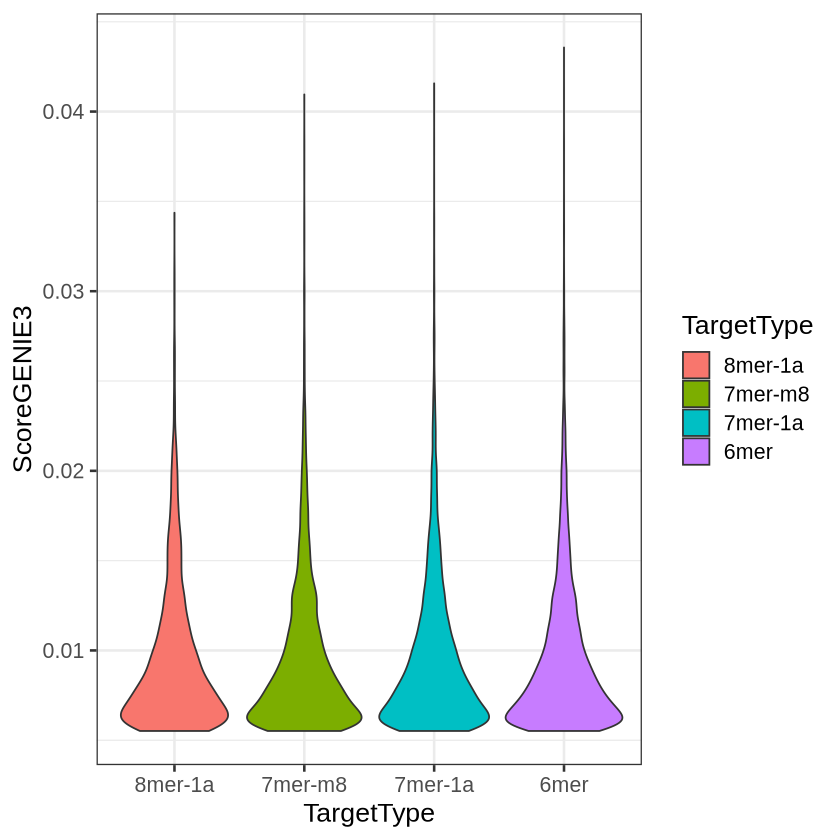

In [77]:
ggplot(common_rel, aes(x = TargetType, y = ScoreGENIE3, fill = TargetType)) +
  geom_violin()

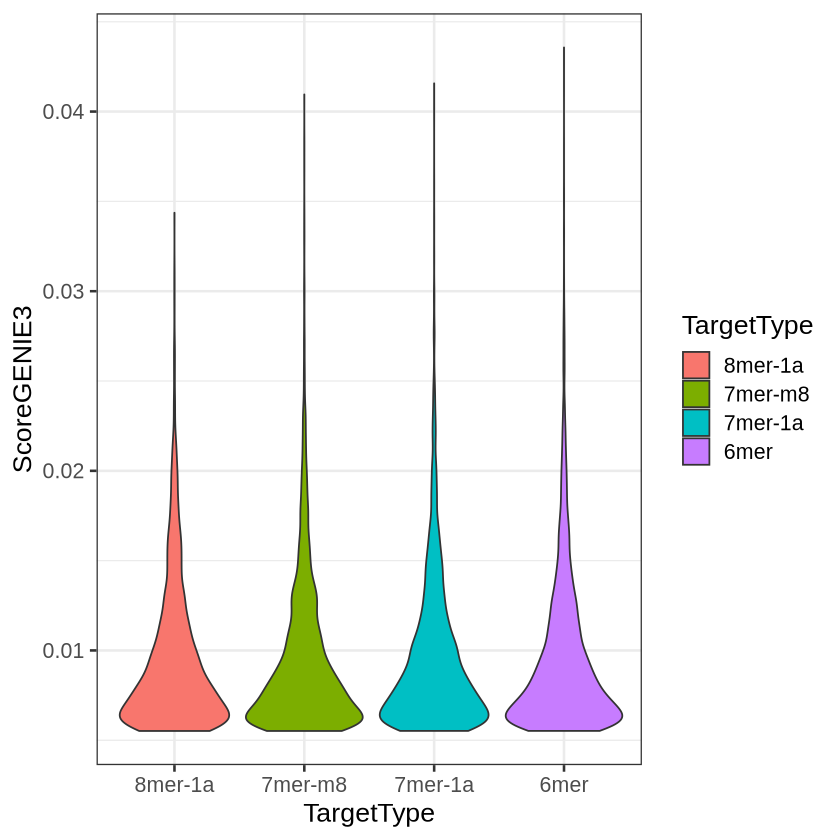

In [78]:
#best target type for a couple
ggplot(common_rel_filtered, aes(x = TargetType, y = ScoreGENIE3, fill = TargetType)) +
  geom_violin()

### Ranking of GENIE3 score for common relationships

In [80]:
common_rel_sorted= common_rel[order(-(common_rel$ScoreGENIE3)), ]
common_rel_sorted$Rank = 1:nrow(common_rel_sorted)
head(common_rel_sorted)

RegulatoryGene TargetGene       ScoreGENIE3 Biotype NbTranscripts
25060 mirdeep2.6179  LOC_000000047312 0.04356880  mRNA     8           
22612 mirdeep2.5915  LOC_000000005665 0.04265853  lncRNA  19           
26216 mirdeep2.6294  LOC_000000004037 0.04157052  mRNA     2           
24935 mirdeep2.6179  LOC_000000003282 0.04134631  mRNA    10           
24954 mirdeep2.6179  LOC_000000005340 0.04095355  mRNA    14           
24955 mirdeep2.6179  LOC_000000005340 0.04095355  mRNA    14           
      Value         Correlation TargetType Rank
25060 -0.7484745416 -           6mer       1   
22612 -0.5631590021 -           6mer       2   
26216 -0.0005535483 -           7mer-1a    3   
24935 -0.7733030037 -           6mer       4   
24954 -0.8251260311 -           7mer-m8    5   
24955 -0.8251260311 -           6mer       6

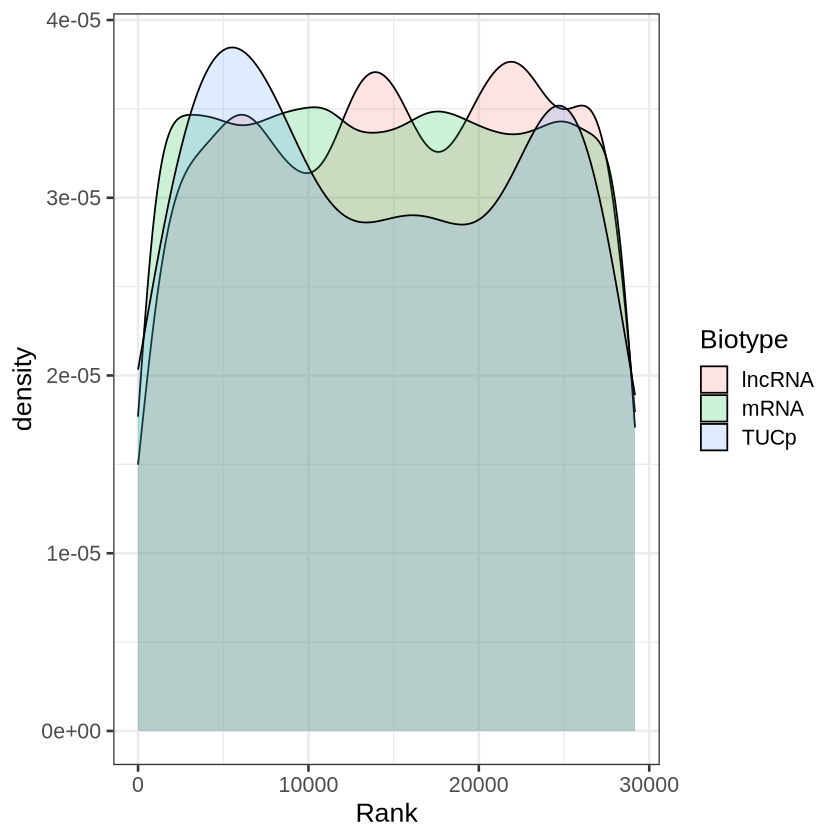

In [82]:
ggplot()+ geom_density(data=common_rel_sorted,aes(x=Rank,y = after_stat(density), fill=Biotype),alpha=.2)

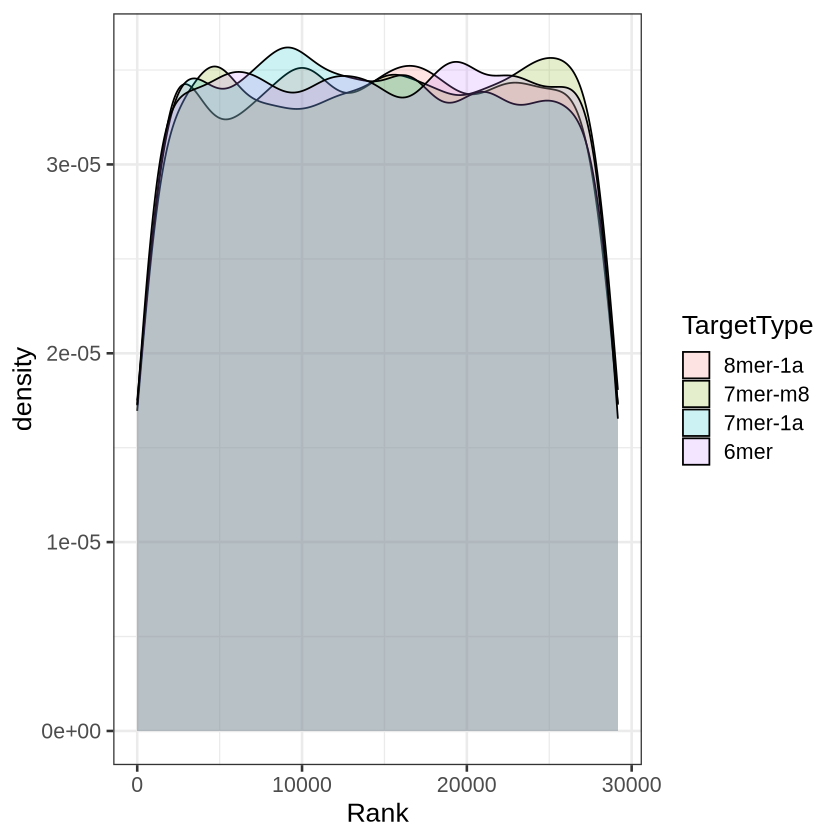

In [84]:
ggplot()+ geom_density(data=common_rel_sorted,aes(x=Rank,y = after_stat(density), fill=TargetType),alpha=.2)

In [81]:
#Meilleure TargetType par couple
common_rel_filtered_sorted= common_rel_filtered[order(-(common_rel_filtered$ScoreGENIE3)), ]
common_rel_filtered_sorted$Rank = 1:nrow(common_rel_filtered_sorted)
head(common_rel_filtered_sorted)

RegulatoryGene TargetGene       ScoreGENIE3 Biotype NbTranscripts
1 mirdeep2.6179  LOC_000000047312 0.04356880  mRNA     8           
2 mirdeep2.5915  LOC_000000005665 0.04265853  lncRNA  19           
3 mirdeep2.6294  LOC_000000004037 0.04157052  mRNA     2           
4 mirdeep2.6179  LOC_000000003282 0.04134631  mRNA    10           
5 mirdeep2.6179  LOC_000000005340 0.04095355  mRNA    14           
6 mirdeep2.6179  LOC_000000007890 0.04009405  mRNA    11           
  Value         Correlation TargetType Rank
1 -0.7484745416 -           6mer       1   
2 -0.5631590021 -           6mer       2   
3 -0.0005535483 -           7mer-1a    3   
4 -0.7733030037 -           6mer       4   
5 -0.8251260311 -           7mer-m8    5   
6 -0.7120423801 -           7mer-1a    6

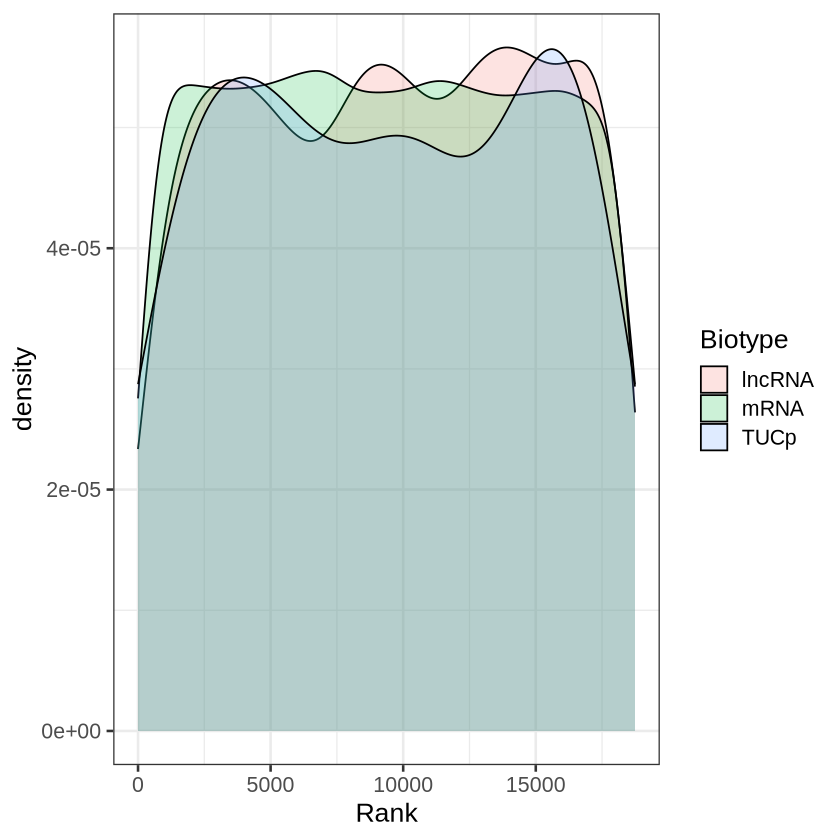

In [83]:
#Meilleure TargetType par couple
ggplot()+ geom_density(data=common_rel_filtered_sorted,aes(x=Rank,y = after_stat(density), fill=Biotype),alpha=.2)

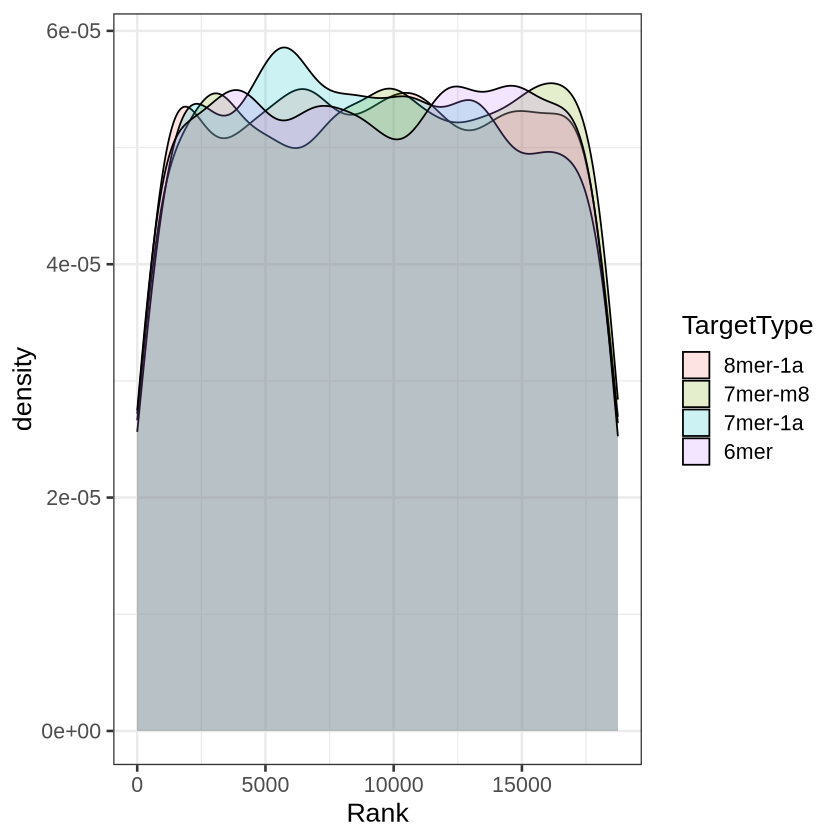

In [85]:
#Meilleure TargetType par couple
ggplot()+ geom_density(data=common_rel_filtered_sorted,aes(x=Rank,y = after_stat(density), fill=TargetType),alpha=.2)

# Gene count

In [86]:
length(unique(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$TargetGene)) #33914 genes in subset GENIE3

[1] 33914

In [87]:
length(unique(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$TargetGene[which(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$Correlation == "-" )]))
#30475 genes in subset GENIE3 with negative correlation

[1] 30475

In [88]:
length(unique(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$TargetGene[which(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$Correlation == "+" )]))
#33840 genes in subset GENIE3 with positive correlation

[1] 33840

In [89]:
length(unique(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$TargetGene[which(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$Status == "Common")])) 
#16548 genes in common

[1] 16548

In [90]:
length(unique(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$TargetGene[which(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$Status == "Common" &relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$Correlation == "-" )]))
#9074 genes in common with negative correlation

[1] 9074

In [91]:
length(unique(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$TargetGene[which(relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$Status == "Common" &relationships_by_couple_subsetGENIE3_threshold_1M_corr_status$Correlation == "+" )]))
#14739 genes in common with positive correlation

[1] 14739

In [92]:
length(unique(relationships_by_couple_Targetscan_corr_status$TargetGene)) #20031 genes in Targetscan

[1] 20031

In [93]:
length(unique(relationships_by_couple_Targetscan_corr_status$TargetGene[which(relationships_by_couple_Targetscan_corr_status$Correlation == "-" )]))
#19952 genes in subset Targetscan with negative correlation

[1] 19952

In [94]:
length(unique(relationships_by_couple_Targetscan_corr_status$TargetGene[which(relationships_by_couple_Targetscan_corr_status$Correlation == "+" )]))
#19922 genes in subset Targetscan with positive correlation

[1] 19922

# Target gene biotype

### GENIE3

In [95]:
#GENIE3
percentage_data <- relationships_by_couple_subsetGENIE3_threshold_1M_corr_status %>%
  group_by(Status, Biotype,Correlation) %>%
  summarise(count = n()) %>%
  mutate(percentage = count / sum(count) * 100)

biotype_cor_subset_GENIE3 = ggplot(percentage_data, aes(x = Biotype, y = percentage, fill = Correlation, label = round(percentage, 1))) +
  geom_bar(stat = "identity", position = "dodge") +
  geom_text(position = position_dodge(width = 0.9), vjust = -0.5) +
  facet_grid(~Status)

`summarise()` has grouped output by 'Status', 'Biotype'. You can override using
the `.groups` argument.


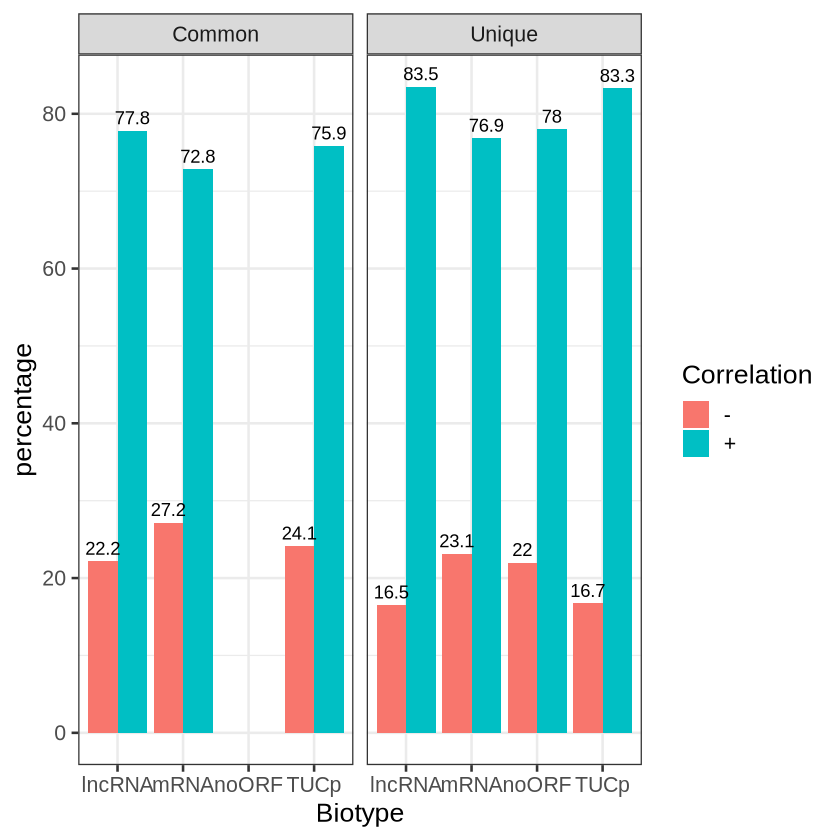

In [96]:
biotype_cor_subset_GENIE3

In [97]:
ggsave(biotype_cor_subset_GENIE3,file="/home/ocarpentier/work/figures/biotype_cor_subset_GENIE3_threshold_1M.png")

Saving 6.67 x 6.67 in image


### TargetScan

`summarise()` has grouped output by 'Status', 'Biotype'. You can override using
the `.groups` argument.


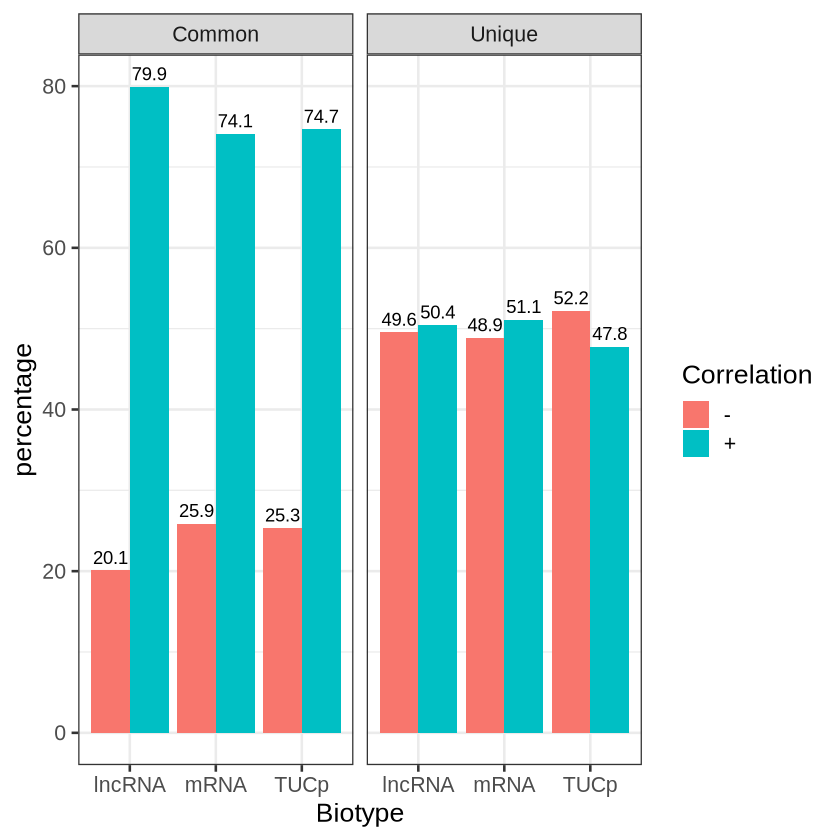

In [98]:
#Targetscan
percentage_data <- relationships_by_couple_Targetscan_corr_status %>%
  group_by(Status, Biotype,Correlation) %>%
  summarise(count = n()) %>%
  mutate(percentage = count / sum(count) * 100)

filtered_percentage_data <- percentage_data[!is.na(percentage_data$Correlation), ]

ggplot(filtered_percentage_data, aes(x = Biotype, y = percentage, fill = Correlation, label = round(percentage, 1))) +
  geom_bar(stat = "identity", position = "dodge") +
  geom_text(position = position_dodge(width = 0.9), vjust = -0.5) +
  facet_grid(~Status)

In [99]:
filtered_data = relationships_by_couple_Targetscan_corr_status %>% distinct(RegulatoryGene, TargetGene,Biotype, Correlation, Status, .keep_all = FALSE)
percentage_data <- filtered_data %>%
  group_by(Status, Biotype,Correlation) %>%
  summarise(count = n()) %>%
  mutate(percentage = count / sum(count) * 100)

filtered_percentage_data <- percentage_data[!is.na(percentage_data$Correlation), ]

biotype_cor_subset_Targetscan = ggplot(filtered_percentage_data, aes(x = Biotype, y = percentage, fill = Correlation, label = round(percentage, 1))) +
  geom_bar(stat = "identity", position = "dodge") +
  geom_text(position = position_dodge(width = 0.9), vjust = -0.5) +
  facet_grid(~Status)

`summarise()` has grouped output by 'Status', 'Biotype'. You can override using
the `.groups` argument.


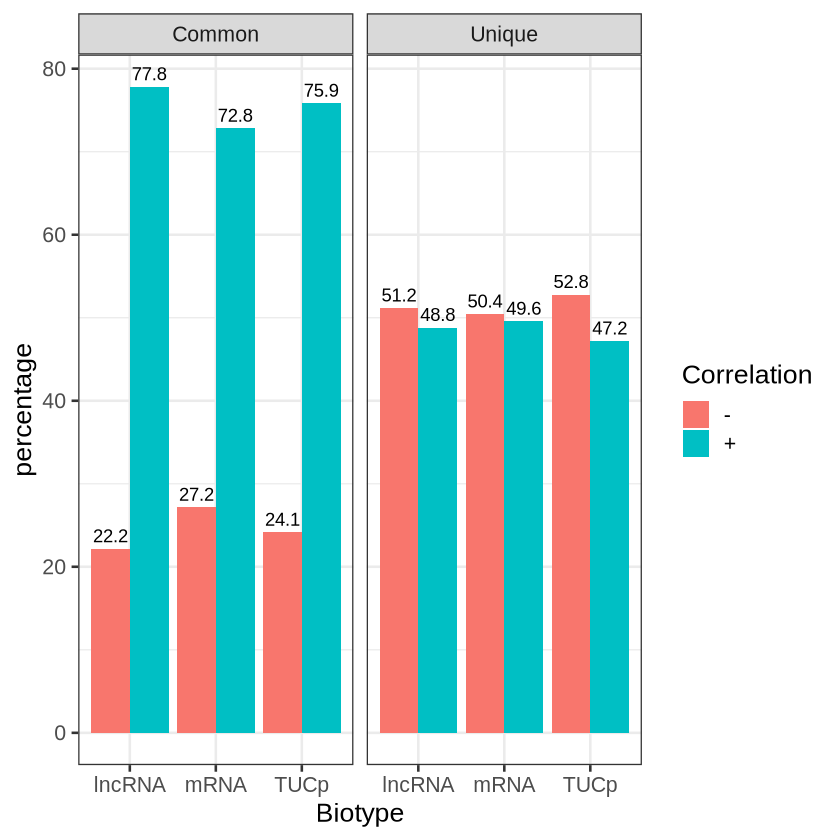

In [100]:
biotype_cor_subset_Targetscan

In [101]:
ggsave(biotype_cor_subset_Targetscan,file="/home/ocarpentier/work/figures/biotype_cor_subset_Targetscan_threshold_1M.png")

Saving 6.67 x 6.67 in image
